In [1]:
from multiprocessing.managers import Value

import copick
import keras.src.losses
import pandas as pd
import zarr
from anyio.abc import value
from keras.src.ops import reshape
from matplotlib import pyplot as plt
import os
import json
import numpy as np
from keras import layers
from matplotlib import patches
import numpy as np
from numba import njit, prange
from scipy.spatial import cKDTree
from collections import defaultdict
from tqdm import tqdm
import tensorflow as tf

In [2]:
def get_copick_root(split):
    """
    Loads the copick configuration based on the split.

    Args:
        split (str): 'train' or 'test'.

    Returns:
        copick_root: The loaded copick configuration.
    """
    config_path = '../../../copick_config.json' if split == 'train' else '../../../copick_config_test.json'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")
    copick_root = copick.from_file(config_path)
    return copick_root


In [3]:
def get_static_tomogram(run_name, split='train', tomo_type='denoised', zarr_group_idx=0):
    """
    Retrieves a static tomogram from the copick dataset.

    Args:
        run_name (str): Name of the run.
        split (str): 'train' or 'test'.
        tomo_type (str): Type of tomogram.
        zarr_group_idx (int): Index of the Zarr group.

    Returns:
        np.ndarray: The tomogram data as a NumPy array.
    """
    copick_root = get_copick_root(split)
    run = copick_root.get_run(run_name)
    voxel_spacing = run.get_voxel_spacing(10.000)
    tomogram = voxel_spacing.get_tomogram(tomo_type)
    zarr_store = tomogram.zarr()
    zarr_group = zarr.open(zarr_store, mode='r')
    try:
        tomogram_vals = zarr_group[str(zarr_group_idx)][:]  # Use string keys if necessary
    except KeyError:
        raise KeyError(f"Zarr group index {zarr_group_idx} not found in the store.")
    return tomogram_vals


In [4]:
# Load copick configurations
copick_root_train = get_copick_root('train')
copick_root_test = get_copick_root('test')

In [5]:
# Retrieve run names
training_runs = copick_root_train.runs
testing_runs = copick_root_test.runs

training_run_names = [run.name for run in training_runs]
testing_run_names = [run.name for run in testing_runs]
extra_training_run_names = list(set(training_run_names) - set(testing_run_names))

print(f'Training runs: {training_run_names}')
print(f'Testing runs: {testing_run_names}')
print(f'Extra training runs not in testing: {extra_training_run_names}')


Training runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
Testing runs: ['TS_5_4', 'TS_69_2', 'TS_6_4']
Extra training runs not in testing: ['TS_99_9', 'TS_86_3', 'TS_6_6', 'TS_73_6']


In [6]:
# Load tomograms
tomograms_train = []
tomograms_test = []

for training_run_name in training_run_names[:1]:
    try:
        tomo = get_static_tomogram(split='train', run_name=training_run_name)
        tomograms_train.append({'run': training_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {training_run_name}: {e}")

for testing_run_name in testing_run_names:
    try:
        tomo = get_static_tomogram(split='test', run_name=testing_run_name)
        tomograms_test.append({'run': testing_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {testing_run_name}: {e}")


print(f'Number of train tomograms: {len(tomograms_train)}')
print(f'Number of test tomograms: {len(tomograms_test)}')


Number of train tomograms: 1
Number of test tomograms: 3


In [7]:
# Verify the loaded tomograms
if tomograms_train:
    sample_tomo = tomograms_train[0]['tomogram']
    print(f"Type: {type(sample_tomo)}")
    print(f"Element Type: {type(sample_tomo[0])}")
    print(f"Shape: {sample_tomo.shape}")
else:
    print("No training tomograms loaded.")


Type: <class 'numpy.ndarray'>
Element Type: <class 'numpy.ndarray'>
Shape: (184, 630, 630)


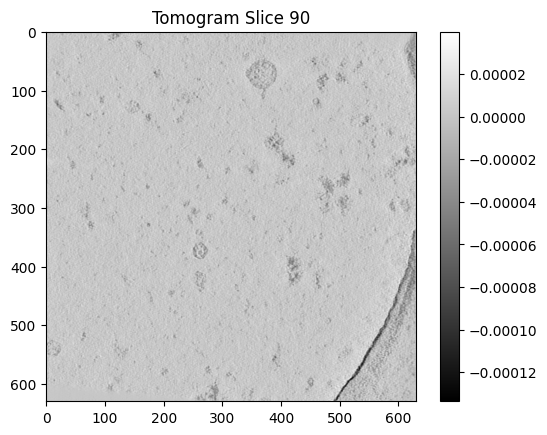

In [8]:
# Visualize a slice
if tomograms_train:
    slice_index = 90  # Adjust as needed
    if slice_index < tomograms_train[0]['tomogram'].shape[0]:
        plt.imshow(tomograms_train[0]['tomogram'][slice_index], cmap='gray')
        plt.title(f"Tomogram Slice {slice_index}")
        plt.colorbar()
        plt.show()
    else:
        print(
            f"Slice index {slice_index} out of range for tomogram with depth {tomograms_train[0]['tomogram'].shape[0]}")
else:
    print("No training tomograms to visualize.")


In [9]:
def get_label_locations(run_name, copick_root, voxel_spacing=10):
    """
    Extracts label locations from JSON files for a given run.

    Args:
        run_name (str): Name of the run.
        copick_root: Copick root object.
        voxel_spacing (float): Voxel spacing for normalization.

    Returns:
        dict: Dictionary with particle names as keys and arrays of locations as values.
    """
    picks_folder = os.path.join(copick_root.config.overlay_root, 'ExperimentRuns', run_name, 'Picks')
    if not os.path.exists(picks_folder):
        raise FileNotFoundError(f"Picks folder not found: {picks_folder}")

    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            particle_name = json_file[:-5]  # Remove '.json' extension
            picks[particle_name] = np.array([
                [
                    point['location']['x'] / voxel_spacing,
                    point['location']['y'] / voxel_spacing,
                    point['location']['z'] / voxel_spacing
                ]
                for point in pick_data.get('points', [])
            ])
    return picks

def get_particle_locations(run_name):
    # Create DataFrame with particle locations
    rows = []
    
    label_data = get_label_locations(run_name, copick_root_train)
    for particle, locations in label_data.items():
        matching_particles = [obj.radius for obj in copick_root_train.config.pickable_objects if obj.name == particle]
        if not matching_particles:
            print(f"No matching particle found for {particle} in run {run}")
            continue
        radius = matching_particles[0] / 10
        for location in locations:
            rows.append({
                'particle': particle,
                'x': location[0],
                'y': location[1],
                'z': location[2],
                'radius': radius
            })
    
    particle_locations_df = pd.DataFrame(rows)
    
    return particle_locations_df

for run in training_run_names:
    particle_locations = get_particle_locations(run)
    for tomo in tomograms_train:
        if tomo['run'] == run:
            tomo['particle_locations']=particle_locations

print(f"Total labeled particles in {tomograms_train[0]['run']}: {len(tomograms_train[0]['particle_locations'])}")
print(f'Sample of particle location in {tomograms_train[0]['run']}:')
print(tomograms_train[0]['particle_locations'].sample(5))

Total labeled particles in TS_5_4: 140
Sample of particle location in TS_5_4:
          particle         x         y        z  radius
118  thyroglobulin  346.9929  375.3490  78.2101    13.0
97    apo-ferritin   61.2529  427.1092  49.4828     6.0
56    beta-amylase  490.8973  174.5891  27.9668     6.5
121  thyroglobulin   75.6786  330.7765  92.3717    13.0
112  thyroglobulin  508.6266  537.8977  41.1051    13.0


In [10]:
unique_particles=pd.DataFrame()
for tomo in tomograms_train:
    unique_particles = pd.concat([unique_particles,tomo['particle_locations'][['particle','radius']].drop_duplicates()],axis=0,ignore_index=True)
unique_particles=unique_particles.drop_duplicates()

particle_types = sorted(unique_particles['particle'].unique())

particle_sizes = {}
for i in unique_particles.to_dict(orient='records'):
    particle_sizes[i['particle']] = i['radius']

# Print the unique particle types and their radii
print("Unique Particle Types and Their Radii:")
print(unique_particles.sort_values(by='radius', ascending=False).reset_index(drop=True))

Unique Particle Types and Their Radii:
              particle  radius
0             ribosome    15.0
1  virus-like-particle    13.5
2        thyroglobulin    13.0
3   beta-galactosidase     9.0
4         beta-amylase     6.5
5         apo-ferritin     6.0


In [11]:
def compute_ground_truth_boxes(df):
    """
    Computes ground truth bounding boxes from particle center points and radii.

    Args:
        df (pd.DataFrame): DataFrame with columns ['run', 'particle', 'x', 'y', 'z', 'radius'].

    Returns:
        np.ndarray: Array of ground truth boxes with shape (N, 6), where each box is (x_min, y_min, z_min, x_max, y_max, z_max).
        np.ndarray: Array of corresponding particle labels (strings).
    """
    # Compute the min and max bounds for each box
    x_min = df['x'] - df['radius']
    x_max = df['x'] + df['radius']
    y_min = df['y'] - df['radius']
    y_max = df['y'] + df['radius']
    z_min = df['z'] - df['radius']
    z_max = df['z'] + df['radius']
    
    # Combine min and max bounds into a single array
    ground_truth_boxes = np.stack([x_min, y_min, z_min, x_max, y_max, z_max], axis=1)
    
   
    # Create a mapping of particle labels to integer IDs
    unique_labels = df['particle'].unique()
    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    id_to_label = {idx:label for label,idx in label_to_id.items()}
    
    # Encode particle labels as integers
    encoded_labels = df['particle'].map(label_to_id).values
    
    return ground_truth_boxes, encoded_labels, label_to_id,id_to_label

for tomo in tomograms_train:
    tomo['ground_truth_boxes'],tomo['ground_truth_labels'],tomo['label_to_id'],tomo['id_to_label'] = compute_ground_truth_boxes(tomo['particle_locations'])

    print(f'Number of ground truth boxes in run {tomo['run']}: {len(tomo['ground_truth_boxes'])}')

gt_sizes = tomograms_train[0]['ground_truth_boxes'][:,4]-tomograms_train[0]['ground_truth_boxes'][:,1]
unique_gt_sizes = np.unique(gt_sizes)
print('Unique ground truth box radii:')
print(np.unique([round(i,4)/2 for i in unique_gt_sizes]))
print('Unique ground truth box diameters:')
print(np.unique([round(i,4) for i in unique_gt_sizes]))

del gt_sizes
del unique_gt_sizes

Number of ground truth boxes in run TS_5_4: 140
Unique ground truth box radii:
[ 6.   6.5  9.  13.  13.5 15. ]
Unique ground truth box diameters:
[12. 13. 18. 26. 27. 30.]


In [12]:
for tomo in tomograms_train:
    # Prepare tomogram for model input
    tomo['tomogram_with_channel'] = np.expand_dims(tomo['tomogram'], axis=-1)  # Add channel dimension
    
print(f"Tomogram Shape: {tomograms_train[0]['tomogram'].shape}")
print(f'Tomogram With Channel Shape: {tomograms_train[0]['tomogram_with_channel'].shape}')

Tomogram Shape: (184, 630, 630)
Tomogram With Channel Shape: (184, 630, 630, 1)


In [13]:
def build_backbone(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    
    # Backbone
    x = layers.Conv3D(32,(3,3,3),activation='relu',padding='same')(inputs)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    x = layers.Conv3D(64,(3,3,3),activation='relu',padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2,2,2),padding='same')(x)
    
    model = keras.Model(inputs=inputs, outputs=x,name='backbone')

    return model

def calculate_cumulative_stride(backbone_model):
    """
    Calculates the cumulative stride of the backbone CNN by traversing its layers.
    
    Args:
        backbone_model (keras.Model): The backbone CNN model.
    
    Returns:
        tuple: Cumulative strides along (z, y, x).
    """
    stride_z, stride_y, stride_x = 1, 1, 1
    for layer in backbone_model.layers:
        if isinstance(layer, layers.MaxPooling3D):
            pool_size = layer.pool_size  # e.g., (2, 2, 2)
            strides = layer.strides      # e.g., (2, 2, 2)
            stride_z *= strides[0]
            stride_y *= strides[1]
            stride_x *= strides[2]
    return stride_z, stride_y, stride_x

backbone = build_backbone(tomograms_train[0]['tomogram_with_channel'].shape)
feature_map = backbone.output
print(f'Input Tomogram Shape: {tomograms_train[0]['tomogram_with_channel'].shape}')
print(f'Feature Map Shape: {feature_map.shape}')

# Calculate 
stride_z, stride_y, stride_x = calculate_cumulative_stride(backbone)
print(f"Cumulative Strides - Z: {stride_z}, Y: {stride_y}, X: {stride_x}")

scales=sorted(np.array(list(particle_sizes.values()))/stride_z*2)
print(f'Anchor box generation scales: {[str(i) for i in scales]}')

aspect_ratios = [(1, 1, 1)]
print(f'Anchor box generation aspect ratios: {aspect_ratios}')
boxes_per_anchors = len(scales) * len(aspect_ratios)

Input Tomogram Shape: (184, 630, 630, 1)
Feature Map Shape: (None, 46, 158, 158, 64)
Cumulative Strides - Z: 4, Y: 4, X: 4
Anchor box generation scales: ['3.0', '3.25', '4.5', '6.5', '6.75', '7.5']
Anchor box generation aspect ratios: [(1, 1, 1)]


In [14]:
def create_anchors(feature_map_shape, scales, aspect_ratios):
    """
    Generates and clips anchor boxes based on the feature map and anchor parameters.

    Args:
        feature_map_shape (tuple): Shape of the feature map (batch_size, D, H, W, C).
        voxel_spacing (float): Voxel spacing used in the tomogram.
        scales (list): List of scales.
        aspect_ratios (list of tuples): List of aspect ratios (w, h, d).

    Returns:
        np.ndarray: Array of clipped anchor boxes with shape (N, 6).
    """
    D, H, W = feature_map_shape[1], feature_map_shape[2], feature_map_shape[3]
    # Define centers based on voxel spacing and feature map stride
    centers_z = np.arange(D)
    centers_y = np.arange(H)
    centers_x = np.arange(W)
    anchor_boxes = generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios)
    anchor_boxes = clip_boxes(anchor_boxes, feature_map_shape)
    return anchor_boxes

def clip_boxes(anchor_boxes, input_shape):
    """
    Clips anchor boxes to lie within the input volume.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes with shape (N, 6).
        input_shape (tuple): Shape of the input volume (D, H, W, C).

    Returns:
        np.ndarray: Clipped anchor boxes.
    """
    D_max, H_max, W_max = input_shape[1], input_shape[2], input_shape[3]
    # Clipping
    anchor_boxes[:, 0] = np.clip(anchor_boxes[:, 0], 0, W_max - 1)  # x_min
    anchor_boxes[:, 1] = np.clip(anchor_boxes[:, 1], 0, H_max - 1)  # y_min
    anchor_boxes[:, 2] = np.clip(anchor_boxes[:, 2], 0, D_max - 1)  # z_min
    anchor_boxes[:, 3] = np.clip(anchor_boxes[:, 3], 0, W_max - 1)  # x_max
    anchor_boxes[:, 4] = np.clip(anchor_boxes[:, 4], 0, H_max - 1)  # y_max
    anchor_boxes[:, 5] = np.clip(anchor_boxes[:, 5], 0, D_max - 1)  # z_max
    return anchor_boxes

def generate_anchor_boxes_vectorized(centers_z, centers_y, centers_x, scales, aspect_ratios, stride=4):
    """
    Efficiently generates anchor boxes using numpy broadcasting with correct shape alignment.
    
    Args:
        centers_z (np.ndarray): Array of center z-coordinates, shape (Nz,)
        centers_y (np.ndarray): Array of center y-coordinates, shape (Ny,)
        centers_x (np.ndarray): Array of center x-coordinates, shape (Nx,)
        scales (list): List of scales, length S
        aspect_ratios (list of tuples): List of aspect ratios (w_ratio, h_ratio, d_ratio), length R
        stride (int): Stride factor between input and feature map
    
    Returns:
        np.ndarray: Array of anchor boxes with shape (Nz * Ny * Nx * S * R, 6), 
                    where each box is (x_min, y_min, z_min, x_max, y_max, z_max)
    """
    # Convert scales and aspect_ratios to NumPy arrays
    scales = np.array(scales)  # Shape: (S,)
    aspect_ratios = np.array(aspect_ratios)  # Shape: (R, 3)
    
    num_scales = scales.shape[0]
    num_ratios = aspect_ratios.shape[0]
    num_sizes = num_scales * num_ratios
    
    # Compute all (w, h, d) combinations
    # Repeat each scale for each aspect ratio
    scales_repeated = np.repeat(scales, num_ratios)  # Shape: (S*R,)
    aspect_ratios_tiled = np.tile(aspect_ratios, (num_scales, 1))  # Shape: (S*R, 3)
    sizes = scales_repeated[:, np.newaxis] * aspect_ratios_tiled  # Shape: (S*R, 3)
    
    # Generate all combinations of center coordinates
    # Using meshgrid with 'ij' indexing to match the nested loop order: z, y, x
    zz, yy, xx = np.meshgrid(centers_z, centers_y, centers_x, indexing='ij')  # Each of shape (Nz, Ny, Nx)
    centers = np.stack([xx, yy, zz], axis=-1).reshape(-1, 3)  # Shape: (Nz*Ny*Nx, 3)
    
    # Scale centers back to input space
    # centers = centers * stride  # Assuming each feature map voxel corresponds to 'stride' in input#
    
    # Number of centers and sizes
    N = centers.shape[0]  # Nz * Ny * Nx
    M = sizes.shape[0]    # S * R
    
    # Expand dimensions to enable broadcasting
    # centers_expanded: (N, 1, 3)
    # sizes_expanded: (1, M, 3)
    centers_expanded = centers[:, np.newaxis, :]  # Shape: (N, 1, 3)
    sizes_expanded = sizes[np.newaxis, :, :]      # Shape: (1, M, 3)
    
    # Compute min and max coordinates
    mins = centers_expanded - sizes_expanded / 2.0  # Shape: (N, M, 3)
    maxs = centers_expanded + sizes_expanded / 2.0  # Shape: (N, M, 3)
    
    # Stack to get (x_min, y_min, z_min, x_max, y_max, z_max)
    anchor_boxes = np.concatenate([mins, maxs], axis=-1).reshape(-1, 6)  # Shape: (N*M, 6)
    
    return anchor_boxes

print('Generating Anchor boxes for each tomogram...')
for tomo in tqdm(tomograms_train):
    # Generate anchor boxes based on the feature map
    tomo['anchor_boxes'] = create_anchors(feature_map.shape, scales, aspect_ratios)
    
print(f"Generated {tomograms_train[-1]['anchor_boxes'].shape[0]} anchor boxes.")
print('Unique anchor box diameters (feature map space):')
print(np.unique(tomograms_train[-1]['anchor_boxes'][:,4]-tomograms_train[-1]['anchor_boxes'][:,1]))
print('Unique anchor box diameters (original image space):')
print(np.unique(tomograms_train[-1]['anchor_boxes'][:,4]-tomograms_train[-1]['anchor_boxes'][:,1])*stride_z)

Generating Anchor boxes for each tomogram...


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

Generated 6890064 anchor boxes.
Unique anchor box diameters (feature map space):
[1.5   1.625 2.25  2.5   2.625 3.    3.25  3.375 3.75  4.25  4.375 4.5
 4.75  5.25  5.375 5.75  6.25  6.375 6.5   6.75  7.5  ]
Unique anchor box diameters (original image space):
[ 6.   6.5  9.  10.  10.5 12.  13.  13.5 15.  17.  17.5 18.  19.  21.
 21.5 23.  25.  25.5 26.  27.  30. ]


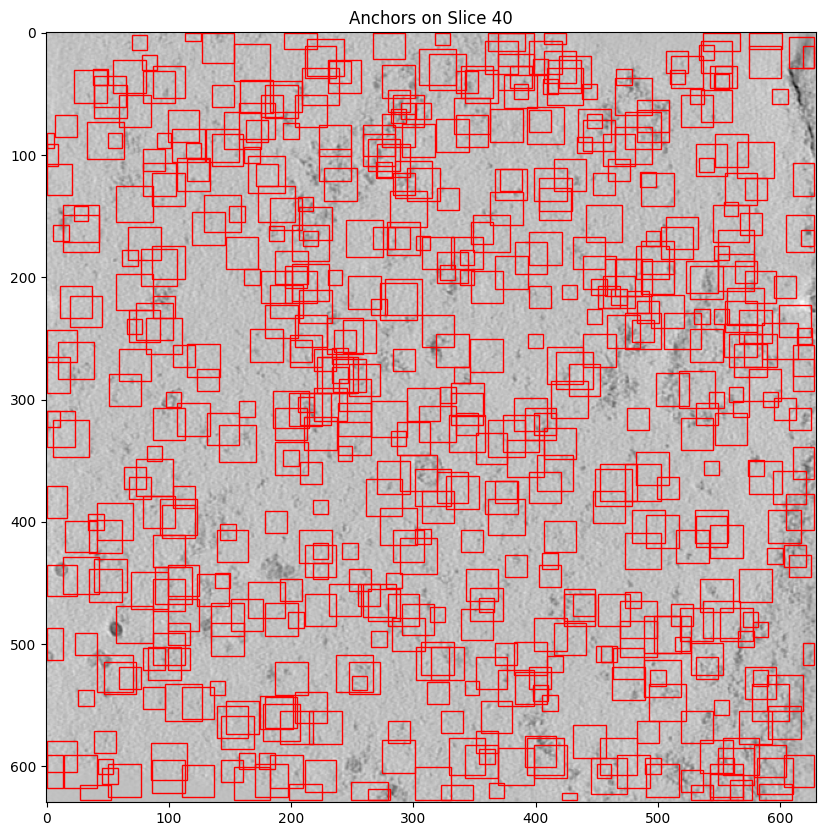

In [15]:
def visualize_anchors(tomogram, anchor_boxes, slice_index,strides, max_anchors=100):
    """
    Visualizes a subset of anchor boxes on a specific slice of the tomogram.

    Args:
        tomogram (np.ndarray): 3D tomogram data.
        anchors (np.ndarray): Array of anchor boxes with shape (N, 6).
        slice_index (int): Index of the slice to visualize.
        max_anchors (int): Maximum number of anchors to visualize.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(tomogram[slice_index], cmap='gray')
    ax = plt.gca()
    count = 0
    
    num_boxes = anchor_boxes.shape[0]
    indices = np.random.choice(num_boxes, size=max_anchors, replace=False)
    random_anchors=anchor_boxes[indices]
    
    for anchor in random_anchors:
        
        # Convert anchor box to image space
        x_min = anchor[0] * strides[0]
        y_min = anchor[1] * strides[1]
        z_min = anchor[2] * strides[2]
        x_max = anchor[3] * strides[0]
        y_max = anchor[4] * strides[1]
        z_max = anchor[5] * strides[2]
        
        if z_min <= slice_index < z_max:
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    plt.title(f"Anchors on Slice {slice_index}")
    plt.show() 
    
# Visualize a subset of anchors on a specific slice
slice_index = 40
strides=stride_z,stride_y,stride_x

visualize_anchors(tomograms_train[0]['tomogram'], tomograms_train[0]['anchor_boxes'], slice_index, strides, max_anchors=5000)

In [16]:
@njit
def floor_div(a, b):
    return np.floor(a / b).astype(np.int32)

def get_grid_indices(boxes, grid_min, grid_cell_size, grid_size):
    """
    Compute the grid cell indices (min and max) for each box.

    Args:
        boxes (np.ndarray): Array of boxes, shape (N, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)

    Returns:
        tuple: min_indices (N,3), max_indices (N,3)
    """
    min_indices = floor_div(boxes[:, :3] - grid_min, np.array(grid_cell_size))
    max_indices = floor_div(boxes[:, 3:6] - grid_min, np.array(grid_cell_size))
    
    # Clamp indices to be within [0, grid_size - 1]
    min_indices = np.maximum(min_indices, 0)
    max_indices = np.minimum(max_indices, np.array(grid_size) - 1)
    
    return min_indices, max_indices

def assign_gt_to_grid(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size):
    """
    Assign GT boxes to grid cells.

    Args:
        ground_truth_boxes_fm (np.ndarray): GT boxes in feature map space, shape (M, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)

    Returns:
        dict: Mapping from grid cell ID to list of GT box indices
    """
    M = ground_truth_boxes_fm.shape[0]
    gt_min_idx, gt_max_idx = get_grid_indices(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size)  # (M,3), (M,3)
    
    grid_dict = defaultdict(list)
    
    for gt_idx in range(M):
        x_min, y_min, z_min = gt_min_idx[gt_idx]
        x_max, y_max, z_max = gt_max_idx[gt_idx]
        
        for x in range(x_min, x_max + 1):
            for y in range(y_min, y_max + 1):
                for z in range(z_min, z_max + 1):
                    grid_id = x * grid_size[1] * grid_size[2] + y * grid_size[2] + z
                    grid_dict[grid_id].append(gt_idx)
    
    return grid_dict

def retrieve_relevant_gt(anchor_boxes, grid_min, grid_cell_size, grid_size, grid_dict, batch_size=10000):
    """
    Retrieve relevant GT boxes for each anchor based on grid cell overlap.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (N, 6)
        grid_min (np.ndarray): Minimum coordinates of the grid, shape (3,)
        grid_cell_size (tuple): Size of each grid cell along (x, y, z)
        grid_size (tuple): Number of grid cells along (x, y, z)
        grid_dict (dict): Mapping from grid cell ID to list of GT box indices
        batch_size (int): Number of anchors to process in each batch

    Returns:
        list of lists: Each sublist contains GT box indices relevant to the anchor
    """
    N = anchor_boxes.shape[0]
    print('Getting grid index for each anchor box')
    anchor_min_idx, anchor_max_idx = get_grid_indices(anchor_boxes, grid_min, grid_cell_size, grid_size)  # (N,3), (N,3)
    
    relevant_gt_per_anchor = [[] for _ in range(N)]
    
    print('Finding relevant ground truth boxes for each anchor')
    for start in tqdm(range(0, N, batch_size)):
        end = min(start + batch_size, N)
        batch_min = anchor_min_idx[start:end]  # (B,3)
        batch_max = anchor_max_idx[start:end]  # (B,3)
        
        for i in range(end - start):
            anchor_idx = start + i
            x_min, y_min, z_min = batch_min[i]
            x_max, y_max, z_max = batch_max[i]
            
            grid_ids = []
            for x in range(x_min, x_max + 1):
                for y in range(y_min, y_max + 1):
                    for z in range(z_min, z_max + 1):
                        grid_id = x * grid_size[1] * grid_size[2] + y * grid_size[2] + z
                        grid_ids.append(grid_id)
            
            gt_indices = []
            for grid_id in grid_ids:
                if grid_id in grid_dict:
                    gt_indices.extend(grid_dict[grid_id])
            
            # Remove duplicates
            gt_indices = list(set(gt_indices))
            relevant_gt_per_anchor[anchor_idx] = gt_indices
    
    return relevant_gt_per_anchor

def compute_iou_3d(boxes1, boxes2):
    """
    Computes IoU between two sets of 3D boxes using float32 for efficiency.

    Args:
        boxes1 (np.ndarray): Shape (N, 6) - [x_min, y_min, z_min, x_max, y_max, z_max].
        boxes2 (np.ndarray): Shape (M, 6) - [x_min, y_min, z_min, x_max, y_max, z_max].

    Returns:
        np.ndarray: IoU array of shape (N,)
    """
    # Compute intersection coordinates
    x_min = np.maximum(boxes1[:, 0], boxes2[:, 0])
    y_min = np.maximum(boxes1[:, 1], boxes2[:, 1])
    z_min = np.maximum(boxes1[:, 2], boxes2[:, 2])
    x_max = np.minimum(boxes1[:, 3], boxes2[:, 3])
    y_max = np.minimum(boxes1[:, 4], boxes2[:, 4])
    z_max = np.minimum(boxes1[:, 5], boxes2[:, 5])

    # Compute intersection dimensions
    inter_w = np.maximum(0, x_max - x_min)
    inter_h = np.maximum(0, y_max - y_min)
    inter_d = np.maximum(0, z_max - z_min)
    intersection = inter_w * inter_h * inter_d  # (N,)

    # Compute volumes
    volume1 = (boxes1[:, 3] - boxes1[:, 0]) * \
              (boxes1[:, 4] - boxes1[:, 1]) * \
              (boxes1[:, 5] - boxes1[:, 2])  # (N,)
    volume2 = (boxes2[:, 3] - boxes2[:, 0]) * \
              (boxes2[:, 4] - boxes2[:, 1]) * \
              (boxes2[:, 5] - boxes2[:, 2])  # (M,)

    # Compute union volume
    union = volume1 + volume2 - intersection  # (N,)

    # Compute IoU
    iou = intersection / np.maximum(union, 1e-6)  # Avoid division by zero

    return iou.astype(np.float32)  # Ensure float32

@njit(parallel=True)
def compute_deltas_batch_numba(anchor_boxes, gt_boxes, stride_array, deltas):
    """
    Numba-accelerated computation of deltas for a batch of anchors and GT boxes.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in image space, shape (K, 6).
                    stride_array (np.ndarray): Stride factors, shape (6,)
        deltas (np.ndarray): Output array for deltas, shape (K, 6).
    """
    K = anchor_boxes.shape[0]
    for i in prange(K):
        # Convert anchor box to image space
        x_min_a = anchor_boxes[i, 0] * stride_array[0]
        y_min_a = anchor_boxes[i, 1] * stride_array[1]
        z_min_a = anchor_boxes[i, 2] * stride_array[2]
        x_max_a = anchor_boxes[i, 3] * stride_array[3]
        y_max_a = anchor_boxes[i, 4] * stride_array[4]
        z_max_a = anchor_boxes[i, 5] * stride_array[5]
        
        # Compute centers and sizes
        x_a = (x_min_a + x_max_a) / 2.0
        y_a = (y_min_a + y_max_a) / 2.0
        z_a = (z_min_a + z_max_a) / 2.0
        w_a = x_max_a - x_min_a
        h_a = y_max_a - y_min_a
        d_a = z_max_a - z_min_a
        
        # GT box in image space
        x_min_g = gt_boxes[i, 0] * stride_array[0]
        y_min_g = gt_boxes[i, 1] * stride_array[1]
        z_min_g = gt_boxes[i, 2] * stride_array[2]
        x_max_g = gt_boxes[i, 3] * stride_array[3]
        y_max_g = gt_boxes[i, 4] * stride_array[4]
        z_max_g = gt_boxes[i, 5] * stride_array[5]
        
        x_g = (x_min_g + x_max_g) / 2.0
        y_g = (y_min_g + y_max_g) / 2.0
        z_g = (z_min_g + z_max_g) / 2.0
        w_g = x_max_g - x_min_g
        h_g = y_max_g - y_min_g
        d_g = z_max_g - z_min_g
        
        # Compute deltas
        dx = (x_g - x_a) / w_a
        dy = (y_g - y_a) / h_a
        dz = (z_g - z_a) / d_a
        dw = np.log(w_g / w_a)
        dh = np.log(h_g / h_a)
        dd = np.log(d_g / d_a)
        
        # Assign to deltas array
        deltas[i, 0] = dx
        deltas[i, 1] = dy
        deltas[i, 2] = dz
        deltas[i, 3] = dw
        deltas[i, 4] = dh
        deltas[i, 5] = dd

def match_anchors_optimized(
    anchor_boxes, 
    ground_truth_boxes_fm, 
    ground_truth_labels, 
    stride=(4,4,4), 
    iou_thresholds=(0.3, 0.7), 
    grid_cell_size=(10.0, 10.0, 10.0)
):
    """
    Optimized matching of anchors to ground truth boxes using grid-based spatial partitioning.

    Args:
        anchor_boxes (np.ndarray): Array of anchor boxes in feature map space with shape (N, 6).
        ground_truth_boxes_fm (np.ndarray): Array of ground truth boxes in feature map space with shape (M, 6).
        ground_truth_labels (np.ndarray): Array of ground truth labels with shape (M,).
        feature_map_shape (tuple): Shape of the feature map (batch_size, D, H, W, C).
        stride (tuple): Stride factors along (z, y, x).
        iou_thresholds (tuple): Tuple of (low_threshold, high_threshold) for negative and positive IoU.
        grid_cell_size (tuple): Size of each grid cell along (x, y, z).

    Returns:
        tuple: (anchor_labels, anchor_deltas, best_gt_idx)
            - anchor_labels (np.ndarray): Labels for each anchor (-1: ignored, -2: background, >0: class labels).
            - anchor_deltas (np.ndarray): Deltas (dx, dy, dz, dw, dh, dd) for each positive anchor.
            - best_gt_idx (np.ndarray): Indices of the best ground truth box for each anchor.
    """
    low_threshold, high_threshold = iou_thresholds
    N = anchor_boxes.shape[0]
    M = ground_truth_boxes_fm.shape[0]
    
    # Initialize labels and deltas
    anchor_labels = np.full(N, -1, dtype=np.int32)      # -1: ignore
    anchor_deltas = np.zeros((N, 6), dtype=np.float32)  # Deltas for positive anchors
    best_gt_idx = np.full(N, -1, dtype=np.int32)       # Best GT index for each anchor
    
    # Compute grid boundaries
    print('Computing grid boundaries')
    all_boxes = np.vstack((anchor_boxes, ground_truth_boxes_fm))
    grid_min = all_boxes[:, :3].min(axis=0)  # (x_min, y_min, z_min)
    grid_max = all_boxes[:, 3:6].max(axis=0)  # (x_max, y_max, z_max)
    
    # Compute grid size
    grid_size = np.ceil((grid_max - grid_min) / grid_cell_size).astype(int)
    grid_size = tuple(grid_size)  # (x_cells, y_cells, z_cells)
    
    # Assign GT boxes to grid cells
    print('Assigning GT boxes to grid cells')
    grid_dict = assign_gt_to_grid(ground_truth_boxes_fm, grid_min, grid_cell_size, grid_size)
    
    # Retrieve relevant GT boxes for each anchor
    print('Retrieving relevant GT boxes for each anchor')
    relevant_gt_per_anchor = retrieve_relevant_gt(anchor_boxes, grid_min, grid_cell_size, grid_size, grid_dict, batch_size=10000)
    
    # Compute deltas requires stride information applied appropriately
    stride_array = np.array([
        stride[2], stride[1], stride[0],  # x, y, z for min coords
        stride[2], stride[1], stride[0]   # x, y, z for max coords
    ], dtype=np.float32)
    
    # Iterate over each anchor to assign labels and compute deltas
    print('Computing IOU between each anchor box and their relevant ground truth boxes and assigning particle labels')
    for anchor_idx in tqdm(range(N)):
        gt_indices = relevant_gt_per_anchor[anchor_idx]
        if len(gt_indices) == 0:
            # No overlapping GT boxes, assign as background
            anchor_labels[anchor_idx] = -2
            continue
        
        # Extract the anchor and relevant GT boxes
        anchor_box = anchor_boxes[anchor_idx].astype(np.float32).reshape(1,6)
        gt_boxes = ground_truth_boxes_fm[gt_indices].astype(np.float32)  # (k,6)
        
        # Compute IoUs
        ious = compute_iou_3d(anchor_box, gt_boxes)  # (k,)
        
        # Find the GT box with the maximum IoU
        max_iou_idx = np.argmax(ious)
        max_iou = ious[max_iou_idx]
        best_gt = gt_indices[max_iou_idx]
        
        if max_iou >= high_threshold:
            try:
                anchor_labels[anchor_idx] = ground_truth_labels[best_gt]
            except ValueError as e:
                print(anchor_idx)
                print(best_gt)
                print(ground_truth_labels[best_gt])
                print(anchor_boxes[anchor_idx])
                raise ValueError(e)
            # Compute deltas
            deltas = compute_iou_deltas(anchor_box, ground_truth_boxes_fm[best_gt].reshape(1,6), stride_array)
            anchor_deltas[anchor_idx] = deltas[0]
            best_gt_idx[anchor_idx] = best_gt
        elif max_iou < low_threshold:
            anchor_labels[anchor_idx] = -2  # Background
        else:
            anchor_labels[anchor_idx] = -1  # Ignore
    
    print('Anchor matching completed.')
    return anchor_labels, anchor_deltas, best_gt_idx

@njit(parallel=True)
def compute_iou_deltas_numba(anchor_boxes, gt_boxes, stride_array, deltas):
    """
    Numba-accelerated computation of deltas for a batch of anchors and GT boxes.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in image space, shape (K, 6).
        stride_array (np.ndarray): Stride factors, shape (6,)
        deltas (np.ndarray): Output array for deltas, shape (K, 6).
    """
    K = anchor_boxes.shape[0]
    for i in prange(K):
        # Convert anchor box to image space
        x_min_a = anchor_boxes[i, 0] * stride_array[0]
        y_min_a = anchor_boxes[i, 1] * stride_array[1]
        z_min_a = anchor_boxes[i, 2] * stride_array[2]
        x_max_a = anchor_boxes[i, 3] * stride_array[3]
        y_max_a = anchor_boxes[i, 4] * stride_array[4]
        z_max_a = anchor_boxes[i, 5] * stride_array[5]
        
        # Compute centers and sizes
        x_a = (x_min_a + x_max_a) / 2.0
        y_a = (y_min_a + y_max_a) / 2.0
        z_a = (z_min_a + z_max_a) / 2.0
        w_a = x_max_a - x_min_a
        h_a = y_max_a - y_min_a
        d_a = z_max_a - z_min_a
        
        # GT box in image space
        x_min_g = gt_boxes[i, 0] * stride_array[0]
        y_min_g = gt_boxes[i, 1] * stride_array[1]
        z_min_g = gt_boxes[i, 2] * stride_array[2]
        x_max_g = gt_boxes[i, 3] * stride_array[3]
        y_max_g = gt_boxes[i, 4] * stride_array[4]
        z_max_g = gt_boxes[i, 5] * stride_array[5]
        
        x_g = (x_min_g + x_max_g) / 2.0
        y_g = (y_min_g + y_max_g) / 2.0
        z_g = (z_min_g + z_max_g) / 2.0
        w_g = x_max_g - x_min_g
        h_g = y_max_g - y_min_g
        d_g = z_max_g - z_min_g
        
        # Compute deltas
        dx = (x_g - x_a) / w_a
        dy = (y_g - y_a) / h_a
        dz = (z_g - z_a) / d_a
        dw = np.log(w_g / w_a)
        dh = np.log(h_g / h_a)
        dd = np.log(d_g / d_a)
        
        # Assign to deltas array
        deltas[i, 0] = dx
        deltas[i, 1] = dy
        deltas[i, 2] = dz
        deltas[i, 3] = dw
        deltas[i, 4] = dh
        deltas[i, 5] = dd

def compute_iou_deltas(anchor_boxes, gt_boxes, stride_array):
    """
    Wrapper function to compute deltas using Numba-accelerated function.

    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map space, shape (K, 6).
        gt_boxes (np.ndarray): Ground truth boxes in feature map space, shape (K, 6).
        stride_array (np.ndarray): Stride factors, shape (6,)

    Returns:
        np.ndarray: Deltas (K, 6)
    """
    K = anchor_boxes.shape[0]
    deltas = np.zeros((K, 6), dtype=np.float32)
    compute_iou_deltas_numba(anchor_boxes, gt_boxes, stride_array, deltas)
    return deltas

grid_cell_size=(5.0, 5.0, 5.0)
stride = (stride_z, stride_y, stride_x)

stride_array = np.array([
    stride[2], stride[1], stride[0],  # x, y, z for min coords
    stride[2], stride[1], stride[0]   # x, y, z for max coords
])

tomogram_sample=1

for idx,tomo in enumerate(tomograms_train):
    print(f'*** Processing tomogram {idx}/{len(tomograms_train)-1} ***')
    
    # Project ground truth boxes to feature map space
    print('Calculating ground truth boxes in feature map space...')
    tomo['ground_truth_boxes_fm'] = tomo['ground_truth_boxes'] / stride_array.reshape(1,6)  # (M,6)
    
    # Perform optimized matching
    tomo['anchor_labels'], tomo['anchor_deltas'], tomo['best_gt_idx'] = match_anchors_optimized(
        anchor_boxes=tomo['anchor_boxes'],
        ground_truth_boxes_fm=tomo['ground_truth_boxes_fm'],
        ground_truth_labels=tomo['ground_truth_labels'],
        stride=stride,
        iou_thresholds=(0.3,0.6),
        grid_cell_size=grid_cell_size
    )

# Verify the number of positive matches
num_positive = np.sum(tomograms_train[0]['anchor_labels'] > -1)
num_background = np.sum(tomograms_train[0]['anchor_labels'] == -2)
num_ignored = np.sum(tomograms_train[0]['anchor_labels'] == -1)
print(f"Number of positive anchors: {num_positive}")
print(f"Number of background anchors: {num_background}")
print(f"Number of ignored anchors: {num_ignored}")

*** Processing tomogram 0/0 ***
Calculating ground truth boxes in feature map space...
Computing grid boundaries
Assigning GT boxes to grid cells
Retrieving relevant GT boxes for each anchor
Getting grid index for each anchor box
Finding relevant ground truth boxes for each anchor


100%|██████████| 690/690 [00:28<00:00, 24.63it/s]


Computing IOU between each anchor box and their relevant ground truth boxes and assigning particle labels


100%|██████████| 6890064/6890064 [00:37<00:00, 183123.21it/s] 


Anchor matching completed.
Number of positive anchors: 1522
Number of background anchors: 6863125
Number of ignored anchors: 25417


In [17]:
for tomo in tomograms_train:
    print(f'Run: {tomo['run']} - {len(np.unique(tomo['best_gt_idx']))-1}/{len(tomo['ground_truth_boxes_fm'])} particles assigned at least one anchor box')

    print('Number of each particle type assigned at least one anchor box:')
    holder={}
    for i,v in zip(tomo['anchor_labels'],tomo['best_gt_idx']):
        if i>-1:
            holder[int(v)]=tomo['id_to_label'][int(i)]
    for particle in particle_types:
        print(f'{particle}: {len([i for i,v in holder.items() if v==particle])}/{len([i for i in tomo['ground_truth_labels'] if i == tomo['label_to_id'][particle]])}')

Run: TS_5_4 - 118/140 particles assigned at least one anchor box
Number of each particle type assigned at least one anchor box:
apo-ferritin: 30/46
beta-amylase: 6/10
beta-galactosidase: 10/12
ribosome: 31/31
thyroglobulin: 30/30
virus-like-particle: 11/11


In [18]:
# import tensorflow as tf
# from keras import layers, Model
# import numpy as np
# 
# def build_rpn(feature_map,particles_count,number_of_anchors):
#     # Shared convolutional layer
#     shared = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(feature_map)
#     
#     # Objectness score branchb
#     objectness = layers.Conv3D(number_of_anchors * particles_count, (1, 1, 1), activation='sigmoid', name='objectness')(shared)
#     
#     # Bounding box regression branch
#     bbox_regression = layers.Conv3D(number_of_anchors*6, (1, 1, 1), activation='linear', name='bbox_regression')(shared)
#     
#     return objectness, bbox_regression
# 
# # Placeholder for RoI Align Layer
# class RoIAlign3D(layers.Layer):
#     def __init__(self, pooled_size=(7, 7, 7), sampling_ratio=2, **kwargs):
#         super(RoIAlign3D, self).__init__(**kwargs)
#         self.pooled_size = pooled_size
#         self.sampling_ratio = sampling_ratio
# 
#     def call(self, feature_map, rois):
#         # Placeholder: Replace this with actual RoI Align logic
#         batch_size = tf.shape(feature_map)[0]
#         num_rois = tf.shape(rois)[1]
#         pooled_depth, pooled_height, pooled_width = self.pooled_size
#         num_channels = feature_map.shape[-1]
# 
#         # Return a dummy tensor for now
#         return tf.zeros((batch_size, num_rois, pooled_depth, pooled_height, pooled_width, num_channels))
# 
# # Detection Head
# def build_detection_head(roi_features, num_classes):
#     x = layers.Flatten()(roi_features)
#     x = layers.Dense(108, activation='relu')(x)
#     x = layers.Dense(108, activation='relu')(x)
# 
#     class_logits = layers.Dense(num_classes, activation='softmax', name='class_logits')(x)
#     bbox_deltas = layers.Dense(6 * num_classes, activation='linear', name='bbox_deltas')(x)
# 
#     return class_logits, bbox_deltas
# 
# class EmbeddedLayer(keras.layers.Layer):
#     def __init__(self, 
#                  iou_threshold=0.7, 
#                  max_proposals=2000, 
#                  **kwargs):
#         super(EmbeddedLayer, self).__init__(**kwargs)
#         self.iou_threshold = iou_threshold
#         self.max_proposals = max_proposals
# 
#     def call(self, inputs):
#         """
#         Args:
#             inputs: A list containing [objectness, bbox_deltas, anchor_boxes]
#                 - objectness: Tensor of shape (batch_size, D, H, W, num_anchors)
#                 - bbox_deltas: Tensor of shape (batch_size, D, H, W, num_anchors * 6)
#                 - anchor_boxes: Tensor of shape (total_anchors, 6)
#         
#         Returns:
#             proposals: Tensor of shape (batch_size, max_proposals, 6)
#         """
#         objectness, bbox_deltas, anchor_boxes = inputs
#         return self.generate_proposals(objectness, bbox_deltas, anchor_boxes)
# 
#     def generate_proposals(self, objectness, bbox_deltas, anchor_boxes):
#         """
#         Generates region proposals based on RPN output using tf.map_fn.
# 
#         Args:
#             objectness: Tensor of shape (batch_size, D, H, W, num_anchors)
#             bbox_deltas: Tensor of shape (batch_size, D, H, W, num_anchors * 6)
#             anchor_boxes: Tensor of shape (total_anchors, 6)
# 
#         Returns:
#             proposals: Tensor of shape (batch_size, max_proposals, 6)
#         """
#         # Reshape objectness and bbox_deltas to (batch_size, total_anchors)
#         batch_size = tf.shape(objectness)[0]
#         total_anchors = tf.shape(anchor_boxes)[0]
# 
#         objectness = tf.reshape(objectness, (batch_size, total_anchors))  # (batch_size, total_anchors)
#         bbox_deltas = tf.reshape(bbox_deltas, (batch_size, total_anchors, 6))  # (batch_size, total_anchors, 6)
# 
#         # Decode bbox_deltas to get proposed boxes
#         proposals = self.decode_deltas(anchor_boxes, bbox_deltas)  # (batch_size, total_anchors, 6)
# 
#         # Clip proposals to image boundaries
#         # Assuming input_shape is known (D, H, W). You might need to pass it or infer it differently.
#         # Here, we'll infer it from the objectness tensor shape (D, H, W)
#         input_shape = tf.shape(objectness)[1:4]  # (D, H, W)
#         proposals = self.clip_boxes(proposals, input_shape)  # (batch_size, total_anchors, 6)
# 
#         # Define a function to apply NMS to each example in the batch
#         def nms_per_example(args):
#             scores, boxes = args
#             selected_indices = tf.image.non_max_suppression(
#                 boxes=boxes,
#                 scores=scores,
#                 max_output_size=self.max_proposals,
#                 iou_threshold=self.iou_threshold
#             )
#             selected_boxes = tf.gather(boxes, selected_indices)
#             # Pad selected_boxes to max_proposals
#             selected_boxes_padded = tf.pad(selected_boxes, 
#                                           [[0, self.max_proposals - tf.shape(selected_boxes)[0]], [0, 0]],
#                                           constant_values=0)
#             selected_boxes_padded = selected_boxes_padded[:self.max_proposals]
#             return selected_boxes_padded
# 
#         # Apply NMS across the batch using tf.map_fn
#         proposals_padded = tf.map_fn(
#             nms_per_example, 
#             (objectness, proposals), 
#             dtype=tf.float32
#         )
# 
#         return proposals_padded  # (batch_size, max_proposals, 6)
# 
#     def decode_deltas(self, anchors, deltas):
#         """
#         Decodes bounding box deltas into final proposals.
# 
#         Args:
#             anchors: Tensor of shape (total_anchors, 6)
#             deltas: Tensor of shape (batch_size, total_anchors, 6)
# 
#         Returns:
#             decoded_boxes: Tensor of shape (batch_size, total_anchors, 6)
#         """
#         # Compute anchor centers and sizes
#         x_a = (anchors[:, 0] + anchors[:, 3]) / 2.0
#         y_a = (anchors[:, 1] + anchors[:, 4]) / 2.0
#         z_a = (anchors[:, 2] + anchors[:, 5]) / 2.0
#         w_a = anchors[:, 3] - anchors[:, 0]
#         h_a = anchors[:, 4] - anchors[:, 1]
#         d_a = anchors[:, 5] - anchors[:, 2]
# 
#         # Expand anchors to match batch size
#         x_a = tf.expand_dims(x_a, axis=0)  # (1, total_anchors)
#         y_a = tf.expand_dims(y_a, axis=0)
#         z_a = tf.expand_dims(z_a, axis=0)
#         w_a = tf.expand_dims(w_a, axis=0)
#         h_a = tf.expand_dims(h_a, axis=0)
#         d_a = tf.expand_dims(d_a, axis=0)
# 
#         # Split deltas
#         dx, dy, dz, dw, dh, dd = tf.split(deltas, num_or_size_splits=6, axis=-1)
# 
#         # Compute proposal centers
#         x_p = x_a + dx * w_a
#         y_p = y_a + dy * h_a
#         z_p = z_a + dz * d_a
# 
#         # Compute proposal sizes
#         w_p = w_a * tf.exp(dw)
#         h_p = h_a * tf.exp(dh)
#         d_p = d_a * tf.exp(dd)
# 
#         # Convert to (x_min, y_min, z_min, x_max, y_max, z_max)
#         x_min = x_p - w_p / 2.0
#         y_min = y_p - h_p / 2.0
#         z_min = z_p - d_p / 2.0
#         x_max = x_p + w_p / 2.0
#         y_max = y_p + h_p / 2.0
#         z_max = z_p + d_p / 2.0
# 
#         decoded_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
#         return decoded_boxes  # (batch_size, total_anchors, 6)
# 
#     def clip_boxes(self, boxes, input_shape):
#         """
#         Clips boxes to lie within the image boundaries.
# 
#         Args:
#             boxes: Tensor of shape (batch_size, total_anchors, 6)
#             input_shape: Tensor of shape (3,) representing (D, H, W)
# 
#         Returns:
#             clipped_boxes: Tensor of shape (batch_size, total_anchors, 6)
#         """
#         D, H, W = input_shape[0], input_shape[1], input_shape[2]
#         x_min, y_min, z_min, x_max, y_max, z_max = tf.split(boxes, num_or_size_splits=6, axis=-1)
# 
#         x_min = tf.clip_by_value(x_min, 0.0, tf.cast(W - 1, tf.float32))
#         y_min = tf.clip_by_value(y_min, 0.0, tf.cast(H - 1, tf.float32))
#         z_min = tf.clip_by_value(z_min, 0.0, tf.cast(D - 1, tf.float32))
#         x_max = tf.clip_by_value(x_max, 0.0, tf.cast(W - 1, tf.float32))
#         y_max = tf.clip_by_value(y_max, 0.0, tf.cast(H - 1, tf.float32))
#         z_max = tf.clip_by_value(z_max, 0.0, tf.cast(D - 1, tf.float32))
# 
#         clipped_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
#         return clipped_boxes  # (batch_size, total_anchors, 6)
# 
#     def compute_output_shape(self, input_shape):
#         """
#         Computes the output shape of the layer.
# 
#         Args:
#             input_shape: List of input shapes [objectness, bbox_deltas, anchor_boxes]
# 
#         Returns:
#             output_shape: (batch_size, max_proposals, 6)
#         """
#         batch_size = input_shape[0][0]
#         return (batch_size, self.max_proposals, 6)
# 
#     def get_config(self):
#         config = super(EmbeddedLayer, self).get_config()
#         config.update({
#             'iou_threshold': self.iou_threshold,
#             'max_proposals': self.max_proposals,
#         })
#         return config
# 
# 
# 
# # Build Faster R-CNN Model
# from keras import layers, Model
# 
# def build_faster_rcnn(input_shape, num_classes, anchor_boxes, num_anchors, max_proposals):
#     inputs = layers.Input(shape=input_shape)
# 
#     print('Creating backbone and feature map...')
#     # Step 1: Backbone network
#     backbone = build_backbone(input_shape)
#     feature_map = backbone(inputs)
# 
#     print('Building RPN...')
#     # Step 2: RPN network feature_map
#     objectness, bbox_deltas = build_rpn(feature_map, num_classes, num_anchors)
# 
#     print('Converting anchor boxes to tensor for proposal layer...')
#     # Convert anchor_boxes to tensor
#     anchor_boxes_tensor = tf.constant(anchor_boxes, dtype=tf.float32)
# 
#     print('Generating proposals from RPN output...')
#     # Step 3: Generate proposals from RPN output
#     # EmbeddedLayer expects [objectness, bbox_deltas, anchor_boxes]
#     proposals = EmbeddedLayer(max_proposals=max_proposals)([objectness, bbox_deltas, anchor_boxes_tensor])
# 
#     print('Building ROI alignment layer...')
#     # Step 4: RoI Align
#     roi_features = RoIAlign3D(pooled_size=(3, 3, 3), sampling_ratio=1)(feature_map, proposals)
# 
#     print('Building detection head...')
#     # Step 5: Detection head
#     class_logits, bbox_deltas_final = build_detection_head(roi_features, num_classes)
# 
#     print('Defining final model...')
#     # Define the final model
#     model = Model(inputs=inputs, outputs=[objectness, bbox_deltas, class_logits, bbox_deltas_final], name="faster_rcnn")
# 
#     return model
# 
# 
# # Build the Faster R-CNN model once
# faster_rcnn_model = build_faster_rcnn(
#     input_shape=tomograms_train[0]['tomogram_with_channel'].shape,
#     num_classes=len(particle_types),
#     anchor_boxes=tomograms_train[0]['anchor_boxes'],
#     num_anchors=boxes_per_anchors,
#     max_proposals=200
# )
# 
# # Display the model summary
# faster_rcnn_model.summary()


In [19]:
# def subdivide_tomogram(tomogram, sub_volume_size, sub_volume_stride):
#     """
#     Subdivide a 3D tomogram into smaller subvolumes.
# 
#     Args:
#         tomogram (np.ndarray): 3D tomogram data.
#         sub_volume_size (tuple): Size of each subvolume (D, H, W).
#         sub_volume_stride (tuple): Stride for moving the window (D, H, W).
# 
#     Returns:
#         list of dict: Each dict contains 'tomogram' and 'origin' (x_start, y_start, z_start).
#     """
#     D, H, W = tomogram.shape
#     sub_D, sub_H, sub_W = sub_volume_size
#     stride_D, stride_H, stride_W = sub_volume_stride
# 
#     subvolumes = []
#     for z in range(0, D - sub_D + 1, stride_D):
#         for y in range(0, H - sub_H + 1, stride_H):
#             for x in range(0, W - sub_W + 1, stride_W):
#                 sub = tomogram[z:z+sub_D, y:y+sub_H, x:x+sub_W]
#                 origin = (x, y, z)  # (x_start, y_start, z_start)
#                 subvolumes.append({'tomogram': sub, 'origin': origin})
#     return subvolumes
# 
# 
# def get_subvolume_ground_truth(df, sub_volume_origin, sub_volume_size, stride=1):
#     """
#     Extract ground truth boxes within a subvolume.
# 
#     Args:
#         df (pd.DataFrame): DataFrame with particle locations and labels.
#         sub_volume_origin (tuple): (x_start, y_start, z_start) of the subvolume.
#         sub_volume_size (tuple): (W, H, D) size of the subvolume.
#         stride (int): Stride factor for normalization if needed.
# 
#     Returns:
#         pd.DataFrame: Ground truth boxes within the subvolume.
#     """
#     x_start, y_start, z_start = sub_volume_origin
#     W, H, D = sub_volume_size
# 
#     # Define the bounds of the subvolume
#     x_end = x_start + W
#     y_end = y_start + H
#     z_end = z_start + D
# 
#     # Filter particles within the subvolume
#     mask = (
#         (df['x'] >= x_start) & (df['x'] < x_end) &
#         (df['y'] >= y_start) & (df['y'] < y_end) &
#         (df['z'] >= z_start) & (df['z'] < z_end)
#     )
#     sub_gt = df[mask].copy()
# 
#     # Adjust coordinates relative to the subvolume origin
#     sub_gt['x'] -= x_start
#     sub_gt['y'] -= y_start
#     sub_gt['z'] -= z_start
# 
#     return sub_gt
# 
# print('Diving tomogram data into subvolumes for batch training...')
# 
# # Subdivide tomograms and keep track of origins
# sub_volume_size = (100, 200, 200)  # (D, H, W)
# sub_volume_stride = (20, 20, 20)   # (D, H, W)
# 
# tomograms_sub_train = []
# for tomo in tomograms_train:
#     subvolumes = subdivide_tomogram(tomo['tomogram'], sub_volume_size, sub_volume_stride)
#     tomograms_sub_train.extend([{'run': tomo['run'], 'tomogram': sub['tomogram'], 'origin': sub['origin']} for sub in subvolumes])
# 
# print(f"Number of training subvolumes: {len(tomograms_sub_train)}")
# 
# print('Assigning ground truth boxes to each subvolume...')
# # Assign ground truth to each subvolume using its specific origin
# for sub in tqdm(tomograms_sub_train):
#     origin = sub['origin']
#     sub_gt = get_subvolume_ground_truth(particle_locations_df, origin, sub_volume_size)
#     sub['ground_truth'] = sub_gt

In [20]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List, Dict

import numpy as np

def convert_anchor_boxes_to_image_space(anchor_boxes: np.ndarray, stride_array: tuple) -> np.ndarray:
    """
    Converts anchor boxes from feature map coordinates to image space coordinates.

    Args:
        anchor_boxes (np.ndarray): 
            A 2D NumPy array of shape (N, 6) representing anchor boxes in feature map coordinates.
            Each anchor box is defined as [x_min, y_min, z_min, x_max, y_max, z_max].
        stride_array (tuple): 
            A tuple of strides defining the scaling between feature map and image space.
            Format: (stride_z, stride_y, stride_x).

    Returns:
        np.ndarray: 
            A 2D NumPy array of shape (N, 6) representing anchor boxes in image space coordinates.
            Each anchor box is defined as [x_min, y_min, z_min, x_max, y_max, z_max].

    Raises:
        ValueError: 
            If `anchor_boxes` is not a 2D array with shape (N, 6).
            If `stride_array` does not contain exactly three positive numerical values.
    """
    # Input Validation
    if not isinstance(anchor_boxes, np.ndarray):
        raise TypeError("anchor_boxes must be a NumPy array.")
    if anchor_boxes.ndim != 2 or anchor_boxes.shape[1] != 6:
        raise ValueError("anchor_boxes must be a 2D NumPy array with shape (N, 6).")
    if not (isinstance(stride_array, tuple) or isinstance(stride_array, list)):
        raise TypeError("stride_array must be a tuple or list of three numerical values.")
    if len(stride_array) != 3:
        raise ValueError("stride_array must contain exactly three elements: (stride_z, stride_y, stride_x).")
    if not all(isinstance(s, (int, float)) and s > 0 for s in stride_array):
        raise ValueError("All elements in stride_array must be positive numbers.")
    
    # Convert anchor_boxes to float32 for precision in calculations
    anchor_boxes = anchor_boxes.astype(np.float32)
    
    # Extract strides
    stride_z, stride_y, stride_x = stride_array
    
    # Initialize a copy to avoid modifying the original anchor_boxes
    image_space_anchors = anchor_boxes.copy()
    
    # Vectorized multiplication to convert from feature map to image space
    # [x_min, y_min, z_min, x_max, y_max, z_max]
    image_space_anchors[:, 0] *= stride_x  # x_min
    image_space_anchors[:, 1] *= stride_y  # y_min
    image_space_anchors[:, 2] *= stride_z  # z_min
    image_space_anchors[:, 3] *= stride_x  # x_max
    image_space_anchors[:, 4] *= stride_y  # y_max
    image_space_anchors[:, 5] *= stride_z  # z_max
    
    return image_space_anchors

# Define stride array: (stride_z, stride_y, stride_x)
stride_array = (4, 4, 4)  # Example strides


for tomo in tomograms_train:
    # Convert anchor boxes to image space
    tomo['anchor_boxes_image_space'] = convert_anchor_boxes_to_image_space(tomo['anchor_boxes'], stride_array)

In [21]:
print(len(tomograms_train))

1


In [22]:
# def convert_anchor_boxes_to_image_space(anchor_boxes: np.ndarray, stride_array: tuple) -> np.ndarray:
#     """
#     Converts anchor boxes from feature map coordinates to image space coordinates.
#     
#     Args:
#         anchor_boxes (np.ndarray): Anchor boxes in feature map coordinates, shape (N, 6).
#         stride_array (tuple): Stride for each axis (stride_z, stride_y, stride_x).
#     
#     Returns:
#         np.ndarray: Anchor boxes in image space coordinates, shape (N, 6).
#     """
#     if anchor_boxes.ndim != 2 or anchor_boxes.shape[1] != 6:
#         raise ValueError("anchor_boxes must be a 2D array with shape (N, 6).")
#     if len(stride_array) != 3 or not all(isinstance(s, (int, float)) and s > 0 for s in stride_array):
#         raise ValueError("stride_array must be a tuple of three positive numbers (stride_z, stride_y, stride_x).")
#     
#     # Multiply x and x_max by stride_x, y and y_max by stride_y, z and z_max by stride_z
#     anchor_boxes_img = anchor_boxes.astype(np.float32).copy()
#     anchor_boxes_img[:, [0, 3]] *= stride_array[2]  # x_min, x_max
#     anchor_boxes_img[:, [1, 4]] *= stride_array[1]  # y_min, y_max
#     anchor_boxes_img[:, [2, 5]] *= stride_array[0]  # z_min, z_max
#     
#     return anchor_boxes_img
# 
# def generate_subvolumes_with_gt_and_anchors(
#     tomograms_train: List[Dict],
#     sub_volume_size: tuple,
#     sub_volume_stride: tuple,
#     stride_array: tuple
# ):
#     """
#     Generator that yields subvolumes from tomograms along with their associated data.
#     
#     Args:
#         tomograms_train (List[Dict]): List of tomogram dictionaries.
#         sub_volume_size (tuple): Size of each subvolume as (D, H, W).
#         sub_volume_stride (tuple): Stride for moving the window as (D, H, W).
#         stride_array (tuple): Stride defining scaling between feature map and image space 
#                               as (stride_z, stride_y, stride_x).
#     
#     Yields:
#         Dict: Dictionary containing subvolume data and associated parameters.
#     """
#     print('Generating subvolumes and assigning ground truth and anchor boxes...')
#     
#     for tomo in tomograms_train:
#         run_name = tomo['run']
#         tomogram = tomo['tomogram']
#         global_anchor_boxes = tomo['anchor_boxes']        # Shape: (N, 6)
#         global_anchor_labels = tomo['anchor_labels']      # Shape: (N,)
#         global_anchor_deltas = tomo['anchor_deltas']      # Shape: (N, 6)
#         particle_locations = tomo['particle_locations']   # Assuming this key exists and is a DataFrame
#         
#         # Convert anchor boxes to image space
#         anchor_boxes_img = convert_anchor_boxes_to_image_space(global_anchor_boxes, stride_array)
#     
#         # Subdivide the tomogram into subvolumes
#         subvolumes = subdivide_tomogram(tomogram, sub_volume_size, sub_volume_stride)
#         
#         if not subvolumes:
#             continue
# 
#         sub_D, sub_H, sub_W = sub_volume_size
#         stride_D, stride_H, stride_W = sub_volume_stride
# 
#         # Ensure data types
#         global_anchor_labels = global_anchor_labels.astype(np.int32)
#         global_anchor_deltas = global_anchor_deltas.astype(np.float32)
# 
#         for sub in subvolumes:
#             sub_tomogram = sub['subvolume']
#             origin = sub['origin']  # (x_start, y_start, z_start)
#             x_start, y_start, z_start = origin
# 
#             # Retrieve ground truth boxes within the subvolume
#             sub_gt = get_subvolume_ground_truth(particle_locations, origin, sub_volume_size)
#             
#             # Compute ground truth bounding boxes and encode labels
#             if not sub_gt.empty:
#                 gt_boxes, gt_labels, label_to_id, id_to_label = compute_ground_truth_boxes(sub_gt)
#             else:
#                 gt_boxes = np.empty((0, 6), dtype=np.float32)
#                 gt_labels = np.empty((0,), dtype=np.int32)
#             
#             # Define subvolume bounds in image coordinates
#             x_end = x_start + sub_W
#             y_end = y_start + sub_H
#             z_end = z_start + sub_D
# 
#             # Vectorized overlap checking
#             overlap_mask = (
#                 (anchor_boxes_img[:, 0] < x_end) & (anchor_boxes_img[:, 3] > x_start) &
#                 (anchor_boxes_img[:, 1] < y_end) & (anchor_boxes_img[:, 4] > y_start) &
#                 (anchor_boxes_img[:, 2] < z_end) & (anchor_boxes_img[:, 5] > z_start)
#             )
# 
#             # Select overlapping anchors
#             if not np.any(overlap_mask):
#                 continue  # No anchors overlap with this subvolume
# 
#             filtered_indices = np.where(overlap_mask)[0]
#             filtered_anchors = global_anchor_boxes[filtered_indices].copy()          # Shape: (num_filtered_anchors, 6)
#             filtered_anchor_labels = global_anchor_labels[filtered_indices].copy()    # Shape: (num_filtered_anchors,)
#             filtered_anchor_deltas = global_anchor_deltas[filtered_indices].copy()    # Shape: (num_filtered_anchors, 6)
# 
#             # Adjust anchor boxes to subvolume coordinates by subtracting origin
#             filtered_anchors[:, 0] -= x_start
#             filtered_anchors[:, 1] -= y_start
#             filtered_anchors[:, 2] -= z_start
#             filtered_anchors[:, 3] -= x_start
#             filtered_anchors[:, 4] -= y_start
#             filtered_anchors[:, 5] -= z_start
# 
#             # Yield the subvolume data
#             yield {
#                 'origin': origin,
#                 'run': run_name,
#                 'subvolume': sub_tomogram.astype(np.float32),          # Shape: (D, H, W)
#                 'anchor_boxes': filtered_anchors.astype(np.float32),   # Shape: (N, 6)
#                 'anchor_labels': filtered_anchor_labels,               # Shape: (N,)
#                 'anchor_deltas': filtered_anchor_deltas,               # Shape: (N, 6)
#                 'ground_truth_boxes': gt_boxes,                        # Shape: (M, 6)
#                 'ground_truth_labels': gt_labels                       # Shape: (M,)
#             }
# 
# def subdivide_tomogram(tomogram: np.ndarray, sub_volume_size: tuple, sub_volume_stride: tuple) -> List[Dict]:
#     """
#     Subdivide a 3D tomogram into smaller subvolumes.
#     
#     Args:
#         tomogram (np.ndarray): 3D tomogram data.
#         sub_volume_size (tuple): Size of each subvolume (D, H, W).
#         sub_volume_stride (tuple): Stride for moving the window (D, H, W).
#     
#     Returns:
#         List[Dict]: Each dict contains 'subvolume' and 'origin' (x_start, y_start, z_start).
#     """
#     D, H, W = tomogram.shape
#     sub_D, sub_H, sub_W = sub_volume_size
#     stride_D, stride_H, stride_W = sub_volume_stride
# 
#     # Calculate the number of steps in each dimension
#     steps_z = max((D - sub_D) // stride_D + 1, 1)
#     steps_y = max((H - sub_H) // stride_H + 1, 1)
#     steps_x = max((W - sub_W) // stride_W + 1, 1)
# 
#     # Precompute the start indices for each dimension
#     starts_z = np.linspace(0, D - sub_D, num=steps_z, dtype=int)
#     starts_y = np.linspace(0, H - sub_H, num=steps_y, dtype=int)
#     starts_x = np.linspace(0, W - sub_W, num=steps_x, dtype=int)
# 
#     # Generate all possible combinations of start indices
#     grid_z, grid_y, grid_x = np.meshgrid(starts_z, starts_y, starts_x, indexing='ij')
#     origins = np.stack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()], axis=1)  # Shape: (num_subvolumes, 3)
# 
#     # Extract subvolumes using advanced indexing
#     subvolumes = []
#     for origin in origins:
#         x_start, y_start, z_start = origin
#         sub = tomogram[z_start:z_start + sub_D, y_start:y_start + sub_H, x_start:x_start + sub_W]
#         subvolumes.append({'subvolume': sub, 'origin': tuple(origin)})
# 
#     return subvolumes
# 
# def get_subvolume_ground_truth(df: pd.DataFrame, sub_volume_origin: tuple, sub_volume_size: tuple) -> pd.DataFrame:
#     """
#     Extract ground truth boxes within a subvolume.
#     
#     Args:
#         df (pd.DataFrame): DataFrame with particle locations and labels.
#         sub_volume_origin (tuple): (x_start, y_start, z_start) of the subvolume.
#         sub_volume_size (tuple): (D, H, W) size of the subvolume.
#     
#     Returns:
#         pd.DataFrame: Ground truth boxes within the subvolume.
#     """
#     x_start, y_start, z_start = sub_volume_origin
#     D, H, W = sub_volume_size
# 
#     # Define the bounds of the subvolume
#     x_end = x_start + W
#     y_end = y_start + H
#     z_end = z_start + D
# 
#     # Filter particles within the subvolume
#     mask = (
#         (df['x'] >= x_start) & (df['x'] < x_end) &
#         (df['y'] >= y_start) & (df['y'] < y_end) &
#         (df['z'] >= z_start) & (df['z'] < z_end)
#     )
#     sub_gt = df[mask].copy()
# 
#     # Adjust coordinates relative to the subvolume origin
#     sub_gt['x'] -= x_start
#     sub_gt['y'] -= y_start
#     sub_gt['z'] -= z_start
# 
#     return sub_gt
# 
# def compute_ground_truth_boxes(df: pd.DataFrame):
#     """
#     Computes ground truth bounding boxes from particle center points and radii.
#     
#     Args:
#         df (pd.DataFrame): DataFrame with columns ['run', 'particle', 'x', 'y', 'z', 'radius'].
#     
#     Returns:
#         tuple: (ground_truth_boxes, ground_truth_labels, label_to_id, id_to_label)
#             - ground_truth_boxes: np.ndarray of shape (N, 6) with (x_min, y_min, z_min, x_max, y_max, z_max)
#             - ground_truth_labels: np.ndarray of shape (N,) with integer labels
#             - label_to_id: dict mapping particle names to integer IDs
#             - id_to_label: dict mapping integer IDs to particle names
#     """
#     if df.empty:
#         return np.empty((0, 6), dtype=np.float32), np.empty((0,), dtype=np.int32), {}, {}
# 
#     # Compute min and max coordinates
#     x_min = df['x'] - df['radius']
#     x_max = df['x'] + df['radius']
#     y_min = df['y'] - df['radius']
#     y_max = df['y'] + df['radius']
#     z_min = df['z'] - df['radius']
#     z_max = df['z'] + df['radius']
# 
#     ground_truth_boxes = np.stack([x_min, y_min, z_min, x_max, y_max, z_max], axis=1).astype(np.float32)
# 
#     # Create a mapping of particle labels to integer IDs
#     unique_labels = df['particle'].unique()
#     label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
#     id_to_label = {idx: label for label, idx in label_to_id.items()}
# 
#     # Encode particle labels as integers
#     ground_truth_labels = df['particle'].map(label_to_id).values.astype(np.int32)
# 
#     return ground_truth_boxes, ground_truth_labels, label_to_id, id_to_label
# 
# 
# 
# sub_volume_size = (100, 200, 200)    # (D, H, W)
# sub_volume_stride = (20, 20, 20)     # (D, H, W)
# 
# processed_subvolumes = generate_subvolumes_with_gt_and_anchors(
#     tomograms_train=tomograms_train,
#     sub_volume_size=sub_volume_size,
#     sub_volume_stride=sub_volume_stride,
#     stride_array=(stride_z, stride_y, stride_x)
# )
# 
# # # Retrieve the first subvolume
# try:
#     first_sub = next(processed_subvolumes)
#     print("Run:", first_sub['run'])
#     print("Origin:", first_sub['origin'])
#     print("Subvolume shape:", first_sub['subvolume'].shape)
#     print("Ground Truth Boxes:", first_sub['ground_truth_boxes'])
#     print("Ground Truth Labels:", first_sub['ground_truth_labels'])
#     print("Anchor Boxes:", first_sub['anchor_boxes'])
# except StopIteration:
#     print("No subvolumes were generated.")

In [23]:
# for i in first_sub.keys():
#     print(i,len(first_sub[i]))
# plt.imshow(first_sub['subvolume'][0])

In [24]:
# def tf_data_generator(processed_subvolumes, batch_size: int):
#     """
#     Generator function to feed data to TensorFlow.
#     
#     Args:
#         processed_subvolumes (Generator[Dict, None, None]): Generator yielding subvolumes.
#         batch_size (int): Number of samples per batch.
#     
#     Yields:
#         Tuple: (inputs, labels)
#             - inputs: Dict containing 'subvolume' and 'anchor_boxes'.
#             - labels: Dict containing 'objectness', 'bbox_regression', and 'mask'.
#     """
#     batch_subvolumes = []
#     batch_anchor_boxes = []
#     batch_objectness = []
#     batch_bbox_regression = []
#     batch_masks = []
#     
#     for sub in processed_subvolumes:
#         # Prepare inputs
#         subvolume = sub['subvolume']  # Shape: (D, H, W)
#         subvolume = np.expand_dims(subvolume, axis=-1)  # Add channel dimension: (D, H, W, 1)
#         batch_subvolumes.append(subvolume.astype(np.float32))
#         
#         anchor_boxes = sub['anchor_boxes']  # Shape: (N, 6)
#         batch_anchor_boxes.append(anchor_boxes.astype(np.float32))
#                   
#         # Prepare labels
#         anchor_labels = sub['anchor_labels']  # Shape: (N,)
#         objectness = np.where(anchor_labels >= 0, 1.0, 0.0).astype(np.float32)  # 1.0 for positive, 0.0 for negative/ignored
#         batch_objectness.append(objectness)
#         
#         bbox_regression = sub['anchor_deltas']  # Shape: (N, 6)
#         batch_bbox_regression.append(bbox_regression.astype(np.float32))
#         
#         mask = np.where(anchor_labels != -1, 1.0, 0.0).astype(np.float32)  # 1.0 for valid anchors, 0.0 for ignored
#         batch_masks.append(mask)
#         
#         # Yield batch if full
#         if len(batch_subvolumes) == batch_size:
#             yield (
#                 {'subvolume': np.array(batch_subvolumes), 'anchor_boxes': tf.ragged.constant(batch_anchor_boxes)},
#                 {'objectness': tf.ragged.constant(batch_objectness),
#                  'bbox_regression': tf.ragged.constant(batch_bbox_regression),
#                  'mask': tf.ragged.constant(batch_masks)}
#             )
#             # Reset batches
#             batch_subvolumes = []
#             batch_anchor_boxes = []
#             batch_objectness = []
#             batch_bbox_regression = []
#             batch_masks = []
#     
#     # Yield remaining data if any
#     if batch_subvolumes:
#         yield (
#             {
#                 'subvolume': np.array(batch_subvolumes),
#                 'anchor_boxes': np.array(batch_anchor_boxes)
#             },
#             {
#                 'objectness': np.array(batch_objectness),
#                 'bbox_regression': np.array(batch_bbox_regression),
#                 'mask': np.array(batch_masks)
#             }
#         )
# 
# import tensorflow as tf
# 
# import tensorflow as tf
# 
# def create_tf_dataset(
#     tomograms_train: List[Dict],
#     sub_volume_size: tuple,
#     sub_volume_stride: tuple,
#     stride_array: tuple,
#     batch_size: int,
#     buffer_size: int = 1000
# ) -> tf.data.Dataset:
#     """
#     Creates a tf.data.Dataset from the subvolume generator using RaggedTensors.
# 
#     Args:
#         tomograms_train (List[Dict]): List of tomogram dictionaries.
#         sub_volume_size (tuple): Size of each subvolume as (D, H, W).
#         sub_volume_stride (tuple): Stride for moving the window as (D, H, W).
#         stride_array (tuple): Stride defining scaling between feature map and image space.
#         batch_size (int): Number of samples per batch.
#         buffer_size (int): Buffer size for shuffling.
# 
#     Returns:
#         tf.data.Dataset: Prepared dataset for training.
#     """
#     # Initialize the generator
#     processed_subvolumes = generate_subvolumes_with_gt_and_anchors(
#         tomograms_train=tomograms_train,
#         sub_volume_size=sub_volume_size,
#         sub_volume_stride=sub_volume_stride,
#         stride_array=stride_array
#     )
#     
#     # Define the generator function
#     generator = tf_data_generator(processed_subvolumes, batch_size)
#         
#     # Define output signatures using RaggedTensors with batch_size
#     output_signature = (
#         {
#             'subvolume': tf.TensorSpec(
#                 shape=(batch_size, sub_volume_size[0], sub_volume_size[1], sub_volume_size[2], 1),
#                 dtype=tf.float32
#             ),
#             'anchor_boxes': tf.RaggedTensorSpec(
#                 shape=[batch_size, None, 6],
#                 dtype=tf.float32
#             )
#         },
#         {
#             'objectness': tf.RaggedTensorSpec(
#                 shape=[batch_size, None],
#                 dtype=tf.float32
#             ),
#             'bbox_regression': tf.RaggedTensorSpec(
#                 shape=[batch_size, None, 6],
#                 dtype=tf.float32
#             ),
#             'mask': tf.RaggedTensorSpec(
#                 shape=[batch_size, None],
#                 dtype=tf.float32
#             )
#         }
#     )
#     
#     # Create the TensorFlow dataset using output_signature
#     dataset = tf.data.Dataset.from_generator(
#         lambda: generator,
#         output_signature=output_signature
#     )
#     
#     # Shuffle and prefetch
#     # dataset = dataset.shuffle(buffer_size=buffer_size)
#     dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
#     
#     return dataset
# 
# # Define your parameters
# sub_volume_size = (100, 200, 200)    # (D, H, W)
# sub_volume_stride = (20, 20, 20)     # (D, H, W)
# stride_array = (stride_z, stride_y, stride_x)  # Define appropriately
# batch_size = 4  # Adjust based on your memory capacity
# 
# # Create the TensorFlow dataset
# tf_dataset = create_tf_dataset(
#     tomograms_train=tomograms_train,
#     sub_volume_size=sub_volume_size,
#     sub_volume_stride=sub_volume_stride,
#     stride_array=stride_array,
#     batch_size=batch_size,
#     buffer_size=1
# )
# 
# 
# 
# 
# 
# # Example: Iterate through one batch
# for batch in tf_dataset.take(1):
#     inputs, labels = batch
#     print("Inputs:")
#     print("Subvolume shape:", inputs['subvolume'].shape)
#     print("Anchor Boxes shape:", inputs['anchor_boxes'].shape)
#     print("Labels:")
#     print("Objectness shape:", labels['objectness'].shape)
#     print("BBox Regression shape:", labels['bbox_regression'].shape)
#     print("Mask shape:", labels['mask'].shape)

In [100]:
import tensorflow as tf
from keras import layers, Model
import numpy as np

def convert_anchor_boxes_to_image_space(anchor_boxes: np.ndarray, stride_array: tuple) -> np.ndarray:
    """
    Converts anchor boxes from feature map coordinates to image space coordinates.
    
    Args:
        anchor_boxes (np.ndarray): Anchor boxes in feature map coordinates, shape (N, 6).
        stride_array (tuple): Stride for each axis (stride_z, stride_y, stride_x).
    
    Returns:
        np.ndarray: Anchor boxes in image space coordinates, shape (N, 6).
    """
    if anchor_boxes.ndim != 2 or anchor_boxes.shape[1] != 6:
        raise ValueError("anchor_boxes must be a 2D array with shape (N, 6).")
    if len(stride_array) != 3 or not all(isinstance(s, (int, float)) and s > 0 for s in stride_array):
        raise ValueError("stride_array must be a tuple of three positive numbers (stride_z, stride_y, stride_x).")
    
    # Multiply x and x_max by stride_x, y and y_max by stride_y, z and z_max by stride_z
    anchor_boxes_img = anchor_boxes.astype(np.float32).copy()
    anchor_boxes_img[:, [0, 3]] *= stride_array[2]  # x_min, x_max
    anchor_boxes_img[:, [1, 4]] *= stride_array[1]  # y_min, y_max
    anchor_boxes_img[:, [2, 5]] *= stride_array[0]  # z_min, z_max
    
    return anchor_boxes_img

def generate_subvolumes_with_gt_and_anchors(
    tomograms_train: List[Dict],
    sub_volume_size: tuple,
    sub_volume_stride: tuple,
    stride_array: tuple
):
    """
    Generator that yields subvolumes from tomograms along with their associated data.
    
    Args:
        tomograms_train (List[Dict]): List of tomogram dictionaries.
        sub_volume_size (tuple): Size of each subvolume as (D, H, W).
        sub_volume_stride (tuple): Stride for moving the window as (D, H, W).
        stride_array (tuple): Stride defining scaling between feature map and image space 
                              as (stride_z, stride_y, stride_x).
    
    Yields:
        Dict: Dictionary containing subvolume data and associated parameters.
    """
    print('Generating subvolumes and assigning ground truth and anchor boxes...')
    
    for tomo in tomograms_train:
        run_name = tomo['run']
        tomogram = tomo['tomogram']
        global_anchor_boxes = tomo['anchor_boxes']        # Shape: (N, 6)
        global_anchor_labels = tomo['anchor_labels']      # Shape: (N,)
        global_anchor_deltas = tomo['anchor_deltas']      # Shape: (N, 6)
        particle_locations = tomo['particle_locations']   # Assuming this key exists and is a DataFrame
        
        # Convert anchor boxes to image space
        anchor_boxes_img = convert_anchor_boxes_to_image_space(global_anchor_boxes, stride_array)
    
        # Subdivide the tomogram into subvolumes
        subvolumes = subdivide_tomogram(tomogram, sub_volume_size, sub_volume_stride)
        
        if not subvolumes:
            continue

        sub_D, sub_H, sub_W = sub_volume_size
        stride_D, stride_H, stride_W = sub_volume_stride

        # Ensure data types
        global_anchor_labels = global_anchor_labels.astype(np.int32)
        global_anchor_deltas = global_anchor_deltas.astype(np.float32)

        for sub in subvolumes:
            sub_tomogram = sub['subvolume']
            origin = sub['origin']  # (x_start, y_start, z_start)
            x_start, y_start, z_start = origin

            # Retrieve ground truth boxes within the subvolume
            sub_gt = get_subvolume_ground_truth(particle_locations, origin, sub_volume_size)
            
            # Compute ground truth bounding boxes and encode labels
            if not sub_gt.empty:
                gt_boxes, gt_labels, label_to_id, id_to_label = compute_ground_truth_boxes(sub_gt)
            else:
                gt_boxes = np.empty((0, 6), dtype=np.float32)
                gt_labels = np.empty((0,), dtype=np.int32)
            
            # Define subvolume bounds in image coordinates
            x_end = x_start + sub_W
            y_end = y_start + sub_H
            z_end = z_start + sub_D

            # Vectorized overlap checking
            overlap_mask = (
                (anchor_boxes_img[:, 0] < x_end) & (anchor_boxes_img[:, 3] > x_start) &
                (anchor_boxes_img[:, 1] < y_end) & (anchor_boxes_img[:, 4] > y_start) &
                (anchor_boxes_img[:, 2] < z_end) & (anchor_boxes_img[:, 5] > z_start)
            )

            # Select overlapping anchors
            if not np.any(overlap_mask):
                continue  # No anchors overlap with this subvolume

            filtered_indices = np.where(overlap_mask)[0]
            filtered_anchors = global_anchor_boxes[filtered_indices].copy()          # Shape: (num_filtered_anchors, 6)
            filtered_anchor_labels = global_anchor_labels[filtered_indices].copy()    # Shape: (num_filtered_anchors,)
            filtered_anchor_deltas = global_anchor_deltas[filtered_indices].copy()    # Shape: (num_filtered_anchors, 6)

            # Adjust anchor boxes to subvolume coordinates by subtracting origin
            filtered_anchors[:, 0] -= x_start
            filtered_anchors[:, 1] -= y_start
            filtered_anchors[:, 2] -= z_start
            filtered_anchors[:, 3] -= x_start
            filtered_anchors[:, 4] -= y_start
            filtered_anchors[:, 5] -= z_start

            # Yield the subvolume data
            yield {
                'origin': origin,
                'run': run_name,
                'subvolume': sub_tomogram.astype(np.float32),          # Shape: (D, H, W)
                'anchor_boxes': filtered_anchors.astype(np.float32),   # Shape: (N, 6)
                'anchor_labels': filtered_anchor_labels,               # Shape: (N,)
                'anchor_deltas': filtered_anchor_deltas,               # Shape: (N, 6)
                'ground_truth_boxes': gt_boxes,                        # Shape: (M, 6)
                'ground_truth_labels': gt_labels                       # Shape: (M,)
            }

def subdivide_tomogram(tomogram: np.ndarray, sub_volume_size: tuple, sub_volume_stride: tuple) -> List[Dict]:
    """
    Subdivide a 3D tomogram into smaller subvolumes.
    
    Args:
        tomogram (np.ndarray): 3D tomogram data.
        sub_volume_size (tuple): Size of each subvolume (D, H, W).
        sub_volume_stride (tuple): Stride for moving the window (D, H, W).
    
    Returns:
        List[Dict]: Each dict contains 'subvolume' and 'origin' (x_start, y_start, z_start).
    """
    D, H, W = tomogram.shape
    sub_D, sub_H, sub_W = sub_volume_size
    stride_D, stride_H, stride_W = sub_volume_stride

    # Calculate the number of steps in each dimension
    steps_z = max((D - sub_D) // stride_D + 1, 1)
    steps_y = max((H - sub_H) // stride_H + 1, 1)
    steps_x = max((W - sub_W) // stride_W + 1, 1)

    # Precompute the start indices for each dimension
    starts_z = np.linspace(0, D - sub_D, num=steps_z, dtype=int)
    starts_y = np.linspace(0, H - sub_H, num=steps_y, dtype=int)
    starts_x = np.linspace(0, W - sub_W, num=steps_x, dtype=int)

    # Generate all possible combinations of start indices
    grid_z, grid_y, grid_x = np.meshgrid(starts_z, starts_y, starts_x, indexing='ij')
    origins = np.stack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()], axis=1)  # Shape: (num_subvolumes, 3)

    # Extract subvolumes using advanced indexing
    subvolumes = []
    for origin in origins:
        x_start, y_start, z_start = origin
        sub = tomogram[z_start:z_start + sub_D, y_start:y_start + sub_H, x_start:x_start + sub_W]
        subvolumes.append({'subvolume': sub, 'origin': tuple(origin)})

    return subvolumes

def get_subvolume_ground_truth(df: pd.DataFrame, sub_volume_origin: tuple, sub_volume_size: tuple) -> pd.DataFrame:
    """
    Extract ground truth boxes within a subvolume.
    
    Args:
        df (pd.DataFrame): DataFrame with particle locations and labels.
        sub_volume_origin (tuple): (x_start, y_start, z_start) of the subvolume.
        sub_volume_size (tuple): (D, H, W) size of the subvolume.
    
    Returns:
        pd.DataFrame: Ground truth boxes within the subvolume.
    """
    x_start, y_start, z_start = sub_volume_origin
    D, H, W = sub_volume_size

    # Define the bounds of the subvolume
    x_end = x_start + W
    y_end = y_start + H
    z_end = z_start + D

    # Filter particles within the subvolume
    mask = (
        (df['x'] >= x_start) & (df['x'] < x_end) &
        (df['y'] >= y_start) & (df['y'] < y_end) &
        (df['z'] >= z_start) & (df['z'] < z_end)
    )
    sub_gt = df[mask].copy()

    # Adjust coordinates relative to the subvolume origin
    sub_gt['x'] -= x_start
    sub_gt['y'] -= y_start
    sub_gt['z'] -= z_start

    return sub_gt

def compute_ground_truth_boxes(df: pd.DataFrame):
    """
    Computes ground truth bounding boxes from particle center points and radii.
    
    Args:
        df (pd.DataFrame): DataFrame with columns ['run', 'particle', 'x', 'y', 'z', 'radius'].
    
    Returns:
        tuple: (ground_truth_boxes, ground_truth_labels, label_to_id, id_to_label)
            - ground_truth_boxes: np.ndarray of shape (N, 6) with (x_min, y_min, z_min, x_max, y_max, z_max)
            - ground_truth_labels: np.ndarray of shape (N,) with integer labels
            - label_to_id: dict mapping particle names to integer IDs
            - id_to_label: dict mapping integer IDs to particle names
    """
    if df.empty:
        return np.empty((0, 6), dtype=np.float32), np.empty((0,), dtype=np.int32), {}, {}

    # Compute min and max coordinates
    x_min = df['x'] - df['radius']
    x_max = df['x'] + df['radius']
    y_min = df['y'] - df['radius']
    y_max = df['y'] + df['radius']
    z_min = df['z'] - df['radius']
    z_max = df['z'] + df['radius']

    ground_truth_boxes = np.stack([x_min, y_min, z_min, x_max, y_max, z_max], axis=1).astype(np.float32)

    # Create a mapping of particle labels to integer IDs
    unique_labels = df['particle'].unique()
    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    id_to_label = {idx: label for label, idx in label_to_id.items()}

    # Encode particle labels as integers
    ground_truth_labels = df['particle'].map(label_to_id).values.astype(np.int32)

    return ground_truth_boxes, ground_truth_labels, label_to_id, id_to_label

def data_generator(tomograms_train: List[Dict], sub_volume_size: tuple, sub_volume_stride: tuple, stride_array: tuple):
    """
    Generator that yields (inputs, labels) for Faster R-CNN training.

    Args:
        tomograms_train (List[Dict]): List of tomogram dictionaries.
        sub_volume_size (tuple): Size of each subvolume (D, H, W).
        sub_volume_stride (tuple): Stride for moving the window (D, H, W).
        stride_array (tuple): Stride for scaling anchor boxes (stride_z, stride_y, stride_x).

    Yields:
        Tuple[Dict, Dict]: (inputs, labels)
            - inputs:
                'subvolume': np.ndarray of shape (D, H, W, 1)
                'anchor_boxes': np.ndarray of shape (N, 6)
            - labels:
                'ground_truth_boxes': np.ndarray of shape (M, 6)
                'ground_truth_labels': np.ndarray of shape (M,)
    """
    
    
    for data in generate_subvolumes_with_gt_and_anchors(tomograms_train, sub_volume_size, sub_volume_stride, stride_array):      
        inputs = {
            'subvolume': data['subvolume'][..., np.newaxis].astype(np.float32),  # Add channel dimension
            'anchor_boxes': data['anchor_boxes'].astype(np.float32)
        }
        labels = {
            'ground_truth_boxes': data['ground_truth_boxes'].astype(np.float32),
            'ground_truth_labels': data['ground_truth_labels'].astype(np.int32)
        }
        yield (inputs, labels)


sub_volume_size = (100, 200, 200)    # (D, H, W)
sub_volume_stride = (20, 20, 20)     # (D, H, W)



# Define output_signature using sub_volume_size
output_signature = (
    {
        'subvolume': tf.TensorSpec(shape=(*sub_volume_size, 1), dtype=tf.float32),  # (100, 200, 200, 1)
        'anchor_boxes': tf.TensorSpec(shape=(None, 6), dtype=tf.float32)            # Variable number of anchors
    },
    {
        'ground_truth_boxes': tf.TensorSpec(shape=(None, 6), dtype=tf.float32),      # Variable number of GT boxes
        'ground_truth_labels': tf.TensorSpec(shape=(None,), dtype=tf.int32)         # Variable number of GT labels
    }
)

# Create the dataset without batching
dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(tomograms_train, sub_volume_size, sub_volume_stride, stride_array),
    output_signature=output_signature
)

# Optionally, shuffle and prefetch
dataset = dataset.shuffle(buffer_size=2).batch(1).prefetch(tf.data.AUTOTUNE)

for batch in dataset.take(1):
    inputs, labels = batch
    print("Subvolume shape:", inputs['subvolume'].shape)          # Expected: (1, 100, 200, 200, 1)
    print("Anchor boxes shape:", inputs['anchor_boxes'].shape)    # Expected: (1, N, 6)
    print("Ground truth boxes shape:", labels['ground_truth_boxes'].shape)    # Expected: (1, M, 6)
    print("Ground truth labels shape:", labels['ground_truth_labels'].shape)  # Expected: (1, M)


def build_rpn(feature_map,particles_count,number_of_anchors):
    # Shared convolutional layer
    shared = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same')(feature_map)
    
    # Objectness score branch
    objectness = layers.Conv3D(number_of_anchors * particles_count, (1, 1, 1), activation='sigmoid', name='objectness')(shared)
    
    # Bounding box regression branch
    bbox_regression = layers.Conv3D(number_of_anchors*6, (1, 1, 1), activation='linear', name='bbox_regression')(shared)
    
    return objectness, bbox_regression

# Placeholder for RoI Align Layer
class RoIAlign3D(layers.Layer):
    def __init__(self, pooled_size=(7, 7, 7), sampling_ratio=2, **kwargs):
        super(RoIAlign3D, self).__init__(**kwargs)
        self.pooled_size = pooled_size
        self.sampling_ratio = sampling_ratio

    def call(self, feature_map, rois):
        # Placeholder: Replace this with actual RoI Align logic
        num_rois = tf.shape(rois)[1]
        pooled_depth, pooled_height, pooled_width = self.pooled_size
        num_channels = feature_map.shape[-1]

        # Return a dummy tensor for now
        return tf.zeros((num_rois, pooled_depth, pooled_height, pooled_width, num_channels))

# Detection Head definition
def build_detection_head(roi_features, num_classes):
    x = layers.Flatten()(roi_features)
    x = layers.Dense(108, activation='relu')(x)
    x = layers.Dense(108, activation='relu')(x)

    class_logits = layers.Dense(num_classes, activation='softmax', name='class_logits')(x)
    bbox_deltas = layers.Dense(6 * num_classes, activation='linear', name='bbox_deltas')(x)

    return class_logits, bbox_deltas

# Proposal Layer definition
class ProposalLayer(keras.layers.Layer):
    def __init__(self, 
                 iou_threshold=0.7, 
                 max_proposals=2000, 
                 **kwargs):
        super(ProposalLayer, self).__init__(**kwargs)
        self.iou_threshold = iou_threshold
        self.max_proposals = max_proposals

    def call(self, inputs):
        """
        Args:
            inputs: A list containing [objectness, bbox_deltas, anchor_boxes]
                - objectness: Tensor of shape (batch_size, D, H, W, num_anchors)
                - bbox_deltas: Tensor of shape (batch_size, D, H, W, num_anchors * 6)
                - anchor_boxes: Tensor of shape (batch_size, total_anchors, 6)
        
        Returns:
            proposals: Tensor of shape (batch_size, max_proposals, 6)
        """   
        objectness, bbox_deltas, anchor_boxes = inputs
        return self.generate_proposals(objectness, bbox_deltas, anchor_boxes)

    def generate_proposals(self, objectness, bbox_deltas, anchor_boxes):
        """
        Generates region proposals based on RPN output using tf.map_fn.

        Args:
            objectness: Tensor of shape (batch_size, D, H, W, num_anchors)
            bbox_deltas: Tensor of shape (batch_size, D, H, W, num_anchors * 6)
            anchor_boxes: Tensor of shape (batch_size, total_anchors, 6)

        Returns:
            proposals: Tensor of shape (batch_size, max_proposals, 6)
        """
        # Reshape objectness and bbox_deltas to (batch_size, total_anchors)
        
        batch_size = tf.shape(objectness)[0]
        total_anchors = tf.shape(anchor_boxes)[1]
        
        spatial_dims = tf.shape(objectness)[1:4]
        
        objectness = tf.reshape(objectness, (batch_size, total_anchors))  # (batch_size, total_anchors)
        bbox_deltas = tf.reshape(bbox_deltas, (batch_size, total_anchors, 6))  # (batch_size, total_anchors, 6)

        # Decode bbox_deltas to get proposed boxes
        proposals = self.decode_deltas(anchor_boxes, bbox_deltas)  # (batch_size, total_anchors, 6)
        
        proposals = self.clip_boxes(proposals, spatial_dims)  # (batch_size, total_anchors, 6)
        
        
        def non_max_suppression_3d(boxes, scores, max_output_size, iou_threshold):
            # Sort boxes by scores in descending order
            sorted_indices = tf.argsort(scores, direction='DESCENDING')
            boxes_sorted = tf.gather(boxes, sorted_indices)
            
            selected_indices = []
            selected_boxes = []
            
            def condition(i, selected_indices, selected_boxes):
                return tf.less(i, tf.shape(boxes_sorted)[0]) and tf.less(tf.size(selected_indices), max_output_size)
            
            def body(i, selected_indices, selected_boxes):
                current_box = boxes_sorted[i]
                selected = tf.stack(selected_boxes) if selected_boxes else tf.constant([], dtype=tf.float32)
                
                if tf.shape(selected)[0] > 0:
                    ious = tf.map_fn(lambda box: compute_iou_3d(current_box, box), selected, dtype=tf.float32)
                    max_iou = tf.reduce_max(ious)
                else:
                    max_iou = 0.0
                
                # If IoU is below the threshold, select the box
                selected_indices, selected_boxes = tf.cond(
                    tf.less(max_iou, iou_threshold),
                    lambda: (tf.concat([selected_indices, [i]], axis=0),
                             tf.concat([selected_boxes, [current_box]], axis=0)),
                    lambda: (selected_indices, selected_boxes)
                )
                return [i + 1, selected_indices, selected_boxes]
            
            i = tf.constant(0)
            selected_indices = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
            selected_boxes = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
            
            i, selected_indices, selected_boxes = tf.while_loop(
                cond=condition,
                body=body,
                loop_vars=[i, selected_indices, selected_boxes]
            )
            
            selected_indices = selected_indices.stack()
            selected_boxes = selected_boxes.stack()
            
            return selected_indices, selected_boxes

        
        def nms_per_example(args):
            scores, boxes = args
            
            tf.print("Boxes Shape:", tf.shape(boxes))
            tf.print("Scores Shape:", tf.shape(scores))
            tf.print("Max Proposals:", self.max_proposals)
            tf.print("IOU Threshold:", self.iou_threshold)
            
            selected_indices, selected_boxes = non_max_suppression_3d(
                boxes=boxes,
                scores=scores,
                max_output_size=self.max_proposals,
                iou_threshold=self.iou_threshold
            )
            
            # Gather the selected boxes
            selected_boxes = tf.gather(boxes, selected_indices)
            
            # Calculate padding size
            num_selected = tf.shape(selected_boxes)[0]
            padding_size = self.max_proposals - num_selected
            padding_size = tf.maximum(padding_size, 0)  # Ensure non-negative
            
            # Pad selected_boxes to max_proposals
            selected_boxes_padded = tf.pad(
                selected_boxes, 
                [[0, padding_size], [0, 0]],
                constant_values=0
            )
            selected_boxes_padded = selected_boxes_padded[:self.max_proposals]
            return selected_boxes_padded

        # Apply NMS across the batch using tf.map_fn
        proposals_padded = tf.map_fn(nms_per_example, (objectness, proposals), dtype=tf.float32)

        return proposals_padded  # (batch_size, max_proposals, 6)

    def decode_deltas(self, anchors, deltas):
        """
        Decodes bounding box deltas into final proposals.

        Args:
            anchors: Tensor of shape (total_anchors, 6)
            deltas: Tensor of shape (batch_size, total_anchors, 6)

        Returns:
            decoded_boxes: Tensor of shape (batch_size, total_anchors, 6)
        """
        # Compute anchor centers and sizes
        x_a = (anchors[:, 0] + anchors[:, 3]) / 2.0
        y_a = (anchors[:, 1] + anchors[:, 4]) / 2.0
        z_a = (anchors[:, 2] + anchors[:, 5]) / 2.0
        w_a = anchors[:, 3] - anchors[:, 0]
        h_a = anchors[:, 4] - anchors[:, 1]
        d_a = anchors[:, 5] - anchors[:, 2]

        # Expand anchors to match batch size
        x_a = tf.expand_dims(x_a, axis=0)  # (1, total_anchors)
        y_a = tf.expand_dims(y_a, axis=0)
        z_a = tf.expand_dims(z_a, axis=0)
        w_a = tf.expand_dims(w_a, axis=0)
        h_a = tf.expand_dims(h_a, axis=0)
        d_a = tf.expand_dims(d_a, axis=0)

        # Split deltas
        dx, dy, dz, dw, dh, dd = tf.split(deltas, num_or_size_splits=6, axis=-1)

        # Compute proposal centers
        x_p = x_a + dx * w_a
        y_p = y_a + dy * h_a
        z_p = z_a + dz * d_a

        # Compute proposal sizes
        w_p = w_a * tf.exp(dw)
        h_p = h_a * tf.exp(dh)
        d_p = d_a * tf.exp(dd)

        # Convert to (x_min, y_min, z_min, x_max, y_max, z_max)
        x_min = x_p - w_p / 2.0
        y_min = y_p - h_p / 2.0
        z_min = z_p - d_p / 2.0
        x_max = x_p + w_p / 2.0
        y_max = y_p + h_p / 2.0
        z_max = z_p + d_p / 2.0

        decoded_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
        return decoded_boxes  # (batch_size, total_anchors, 6)

    def clip_boxes(self, boxes, input_shape):
        """
        Clips boxes to lie within the image boundaries.

        Args:
            boxes: Tensor of shape (batch_size, total_anchors, 6)
            input_shape: Tensor of shape (3,) representing (D, H, W)

        Returns:
            clipped_boxes: Tensor of shape (batch_size, total_anchors, 6)
        """
        D, H, W = tf.unstack(input_shape)
        x_min, y_min, z_min, x_max, y_max, z_max = tf.split(boxes, num_or_size_splits=6, axis=-1)

        x_min = tf.clip_by_value(x_min, 0.0, tf.cast(W - 1, tf.float32))
        y_min = tf.clip_by_value(y_min, 0.0, tf.cast(H - 1, tf.float32))
        z_min = tf.clip_by_value(z_min, 0.0, tf.cast(D - 1, tf.float32))
        x_max = tf.clip_by_value(x_max, 0.0, tf.cast(W - 1, tf.float32))
        y_max = tf.clip_by_value(y_max, 0.0, tf.cast(H - 1, tf.float32))
        z_max = tf.clip_by_value(z_max, 0.0, tf.cast(D - 1, tf.float32))

        clipped_boxes = tf.concat([x_min, y_min, z_min, x_max, y_max, z_max], axis=-1)
        return clipped_boxes  # (batch_size, total_anchors, 6)

    def compute_output_shape(self, input_shape):
        """
        Computes the output shape of the layer.

        Args:
            input_shape: List of input shapes [objectness, bbox_deltas, anchor_boxes]

        Returns:
            output_shape: (batch_size, max_proposals, 6)
        """
        batch_size = input_shape[0][0]
        return (batch_size, self.max_proposals, 6)

    def get_config(self):
        config = super(ProposalLayer, self).get_config()
        config.update({
            'iou_threshold': self.iou_threshold,
            'max_proposals': self.max_proposals,
        })
        return config

# Build Faster R-CNN Model
from keras import layers, Model

def build_faster_rcnn(input_shape, num_classes, num_anchors, max_proposals):
    subvolume_input = layers.Input(shape=input_shape, name='subvolume')
    anchor_boxes_input = layers.Input(shape=(None, 6), name='anchor_boxes')
    
    print('ANCHOR BOXES',anchor_boxes_input.shape)

    # Step 1: Backbone network
    print('Creating backbone and feature map...')
    backbone = build_backbone(input_shape)
    feature_map = backbone(subvolume_input)

    # Step 2: RPN network feature_map
    print('Building RPN...')
    objectness, bbox_deltas = build_rpn(feature_map, num_classes, num_anchors)

    # Step 3: Generate proposals from RPN output
    print('Generating proposals from RPN output...')
    proposals = ProposalLayer(max_proposals=max_proposals)([objectness, bbox_deltas, anchor_boxes_input])

    # Step 4: RoI Align
    print('Building ROI alignment layer...')
    roi_features = RoIAlign3D(pooled_size=(3, 3, 3), sampling_ratio=1)(feature_map, proposals)

    # Step 5: Detection head
    print('Building detection head...')
    class_logits, bbox_deltas_final = build_detection_head(roi_features, num_classes)

    # Step 6: Define the final model
    print('Defining final model...')
    model = Model(
        inputs=[subvolume_input, anchor_boxes_input],
        outputs=[objectness, bbox_deltas, class_logits, bbox_deltas_final],
        name="faster_rcnn"
    )

    return model

# Build and compile the model as before
faster_rcnn_model = build_faster_rcnn(
    input_shape=(*sub_volume_size, 1),
    num_classes=len(particle_types),
    num_anchors=boxes_per_anchors,
    max_proposals=200
)

# Compile the model
faster_rcnn_model.compile(
    optimizer='adam',
    loss={
        'objectness': tf.keras.losses.BinaryCrossentropy(from_logits=False),
        'bbox_regression': tf.keras.losses.Huber(),
        'class_logits': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        'bbox_deltas_final': tf.keras.losses.Huber()
    },
    loss_weights={
        'objectness': 1.0,
        'bbox_regression': 1.0,
        'class_logits': 1.0,
        'bbox_deltas_final': 1.0
    }
)

# Display the model summary
# faster_rcnn_model.summary()

# Train the model
faster_rcnn_model.fit(
    dataset,
    steps_per_epoch=10,  # Adjust based on dataset size
    epochs=1
)

Generating subvolumes and assigning ground truth and anchor boxes...
Subvolume shape: (1, 100, 200, 200, 1)
Anchor boxes shape: (1, 478360, 6)
Ground truth boxes shape: (1, 5, 6)
Ground truth labels shape: (1, 5)
ANCHOR BOXES (None, None, 6)
Creating backbone and feature map...
Building RPN...
Generating proposals from RPN output...
Building ROI alignment layer...
Building detection head...
Defining final model...


OperatorNotAllowedInGraphError: Exception encountered when calling ProposalLayer.call().

[1mUsing a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by ProposalLayer.call():
  • inputs=['tf.Tensor(shape=(None, 25, 50, 50, 36), dtype=float32)', 'tf.Tensor(shape=(None, 25, 50, 50, 36), dtype=float32)', 'tf.Tensor(shape=(None, None, 6), dtype=float32)']

In [28]:
# from tensorflow.keras import backend as K
# from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, Huber
# 
# # RPN Objectness Loss
# def rpn_objectness_loss(y_true, y_pred):
#     """
#     Computes binary cross-entropy loss for RPN objectness scores.
#     
#     Args:
#         y_true (Tensor): Ground truth objectness labels (batch_size, N_anchors).
#         y_pred (Tensor): Predicted objectness scores (batch_size, N_anchors).
#     
#     Returns:
#         Tensor: Computed loss.
#     """
#     bce = BinaryCrossentropy(from_logits=False)
#     return bce(y_true, y_pred)
# 
# # RPN Bounding Box Regression Loss
# def rpn_bbox_loss(y_true, y_pred):
#     """
#     Computes Smooth L1 (Huber) loss for RPN bounding box regression.
#     
#     Args:
#         y_true (Tensor): Ground truth bbox deltas (batch_size, N_anchors, 6).
#         y_pred (Tensor): Predicted bbox deltas (batch_size, N_anchors, 6).
#     
#     Returns:
#         Tensor: Computed loss.
#     """
#     huber = Huber(delta=1.0)
#     return huber(y_true, y_pred)
# 
# # Detection Class Loss
# def detection_class_loss(y_true, y_pred):
#     """
#     Computes categorical cross-entropy loss for detection class predictions.
#     
#     Args:
#         y_true (Tensor): Ground truth class labels (batch_size, num_proposals).
#         y_pred (Tensor): Predicted class logits (batch_size, num_proposals, num_classes).
#     
#     Returns:
#         Tensor: Computed loss.
#     """
#     sce = SparseCategoricalCrossentropy(from_logits=False)
#     return sce(y_true, y_pred)
# 
# # Detection Bounding Box Regression Loss
# def detection_bbox_loss(y_true, y_pred):
#     """
#     Computes Smooth L1 (Huber) loss for detection bounding box regression.
#     
#     Args:
#         y_true (Tensor): Ground truth bbox deltas (batch_size, num_proposals, 6).
#         y_pred (Tensor): Predicted bbox deltas (batch_size, num_proposals, 6 * num_classes).
#     
#     Returns:
#         Tensor: Computed loss.
#     """
#     # Reshape y_pred to (batch_size, num_proposals, num_classes, 6)
#     num_classes = y_pred.shape[-1] // 6
#     y_pred = K.reshape(y_pred, (-1, K.shape(y_pred)[1], num_classes, 6))
#     
#     # Assuming y_true has the same number of proposals as y_pred's first class
#     # You may need to align y_true with the correct class predictions
#     # For simplicity, we'll compute loss across all classes
#     huber = Huber(delta=1.0)
#     return huber(y_true, y_pred)
# 
# from tensorflow.keras.optimizers import Adam
# 
# # Number of classes (including background if applicable)
# num_classes = len(particle_types)  # Replace with your actual number
# 
# # Compile the model
# faster_rcnn_model.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss={
#         'objectness': rpn_objectness_loss,
#         'bbox_regression': rpn_bbox_loss,
#         'class_logits': detection_class_loss,
#         'bbox_deltas': detection_bbox_loss
#     },
#     metrics={
#         'objectness': ['accuracy'],
#         'class_logits': ['accuracy'],
#         # Add more metrics if needed
#     }
# )


In [46]:
# Train the model
faster_rcnn_model.fit(
    dataset,
    steps_per_epoch=10,  # Adjust based on dataset size
    epochs=1
)

ValueError: Input 0 of layer "faster_rcnn" is incompatible with the layer: expected shape=(None, 100, 200, 200, 1), found shape=(100, 200, 200)